In [74]:
import os
import requests
import shapely
import json

# !pip install pydotplus
from sklearn import tree
# from IPython.display import Image  
# import pydotplus

import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline
#import statsmodels.formula.api as smf
import itertools
import geopandas as gpd
from shapely.geometry import Point, Polygon
from sklearn.metrics import silhouette_score
# from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage  # for hierarchical clustering
from scipy.cluster.hierarchy import fcluster
# from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import geopandas as gpd
import pylab as pl
import io
import pylab as pl

from geopandas.tools import sjoin
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False
#from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pylab


%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Polygon', 'linalg', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_[:]
    indices = np.argsort(importances)[::-1]
    #std = np.std([tree.feature_importances_ for tree in rf.estimators_],
    #         axis=0)

    pl.figure(figsize=(16,16))
    pl.title("Feature importances")
    pl.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", #yerr=std[indices]
           align="center")
    pl.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    pl.xlim([-1, indices.shape[0]])
    pl.show()
#featureImportancePlot(rf, X_foursquare.columns)

## Data Processing

This section combines the raw dataset with the typology and NYC shape file

In [2]:
twitter = pd.read_csv('Data/NYtwitter_output_12_17.csv')

In [3]:
NYCzip = gpd.read_file('shape7/region.shp')

In [4]:
typ = pd.read_excel('Data/NY final data for typologies 1.19.19.xlsx')

In [5]:
typ['Type_1.19'].replace('MHI - Advanced Exclusion', 'MHI - Ongoing Exclusion', inplace=True)

In [6]:
alldata = twitter.merge(typ, right_on="geoid", left_on="tract")

In [7]:
NYCzip['geojoin']=NYCzip['geoid'].astype(float)

In [46]:
full = NYCzip.merge(alldata, right_on="geoid", left_on="geojoin")

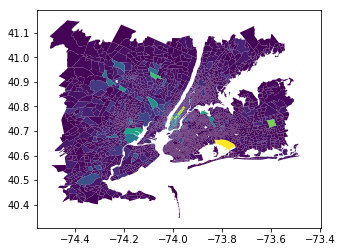

In [47]:
full.plot(column='other_tweets')

In [48]:
#creating twitter metrics
full["localpercentage"]=full.local_tweets/full.total_tweets
full["nbrpercentage"]=full.neighbor_tweets/full.total_tweets
full["visitorpercentage"]=full.other_tweets/full.total_tweets

MHI - Stable or Early Stage of Exclusion              1083
MHI - Ongoing Exclusion                                527
LI - Not Losing Low-Income Households                  402
LI - At Risk of Gentrification                         377
LI - Ongoing Displacement of Low-Income Households     361
LI - Ongoing Gentrification                            262
MHI - Advanced Gentrification                          194
VHI - Super Gentrification or Exclusion                179
Missing Data                                            75
Name: Type_1.19, dtype: int64

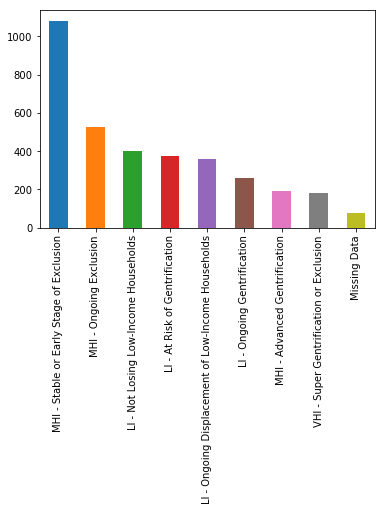

In [49]:
#checking merge results 
full['Type_1.19'].value_counts().plot(kind='bar')
full['Type_1.19'].value_counts()

In [50]:
#creating binary typology
full['Type_binary'] = full['Type_1.19'].copy()
full['Type_binary'].replace('VHI - Super Gentrification or Exclusion',1,inplace=True)
full['Type_binary'].replace('MHI - Ongoing Exclusion',0,inplace=True)
full['Type_binary'].replace('MHI - Stable or Early Stage of Exclusion',0,inplace=True)
full['Type_binary'].replace('MHI - Advanced Exclusion', 0,inplace=True)
full['Type_binary'].replace('MHI - Advanced Gentrification',1,inplace=True)
full['Type_binary'].replace('LI - At Risk of Gentrification',0,inplace=True)
full['Type_binary'].replace('LI - Ongoing Gentrification',1,inplace=True)
full['Type_binary'].replace('LI - Not Losing Low-Income Households',0,inplace=True)
full['Type_binary'].replace('LI - Ongoing Displacement of Low-Income Households',0,inplace=True)
full['Type_binary'].replace('Missing Data',0,inplace=True)
full['Type_binary'].replace(nan,0,inplace=True)

The percent of non-gentrifying is:0.816474


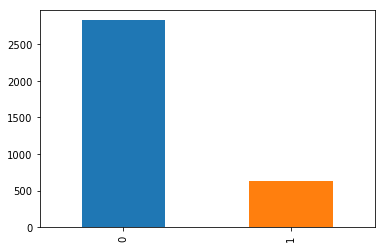

In [51]:
full['Type_binary'].value_counts().plot(kind='bar')
full['Type_binary'].value_counts()
print('The percent of non-gentrifying is:%f'%(full[full['Type_binary'] == 0]['geoid_x'].count()/full['geoid_x'].count()))

In [14]:
list(full.columns)

['aland_mi',
 'objectid',
 'statefp',
 'countyfp',
 'tractce',
 'geoid_x',
 'name',
 'namelsad',
 'mtfcc',
 'funcstat',
 'aland_x',
 'awater',
 'intptlat',
 'intptlon',
 'shape_leng',
 'shape_area',
 'atotal',
 'atotal_mi',
 'cartodb_id',
 'geoid_1',
 'hou16',
 'hou16moe',
 'hou16cv',
 'houv16',
 'houv16moe',
 'houv16cv',
 'houo16',
 'houo16moe',
 'houo16cv',
 'hour16',
 'hour16moe',
 'hour16cv',
 'emtot15',
 'empr15',
 'emoff15',
 'emins15',
 'emind15',
 'emser15',
 'emoth15',
 'geometry',
 'geojoin',
 'tract',
 'total_tweets',
 'miss_home_tract',
 'userwith5_count',
 'total_users',
 'tweets_hometract',
 'tweets_sent_from_home',
 'oddratio_12AM',
 'oddratio_1AM',
 'oddratio_2AM',
 'oddratio_3AM',
 'oddratio_4AM',
 'oddratio_5AM',
 'oddratio_6AM',
 'oddratio_7AM',
 'oddratio_8AM',
 'oddratio_9AM',
 'oddratio_10AM',
 'oddratio_11AM',
 'oddratio_12PM',
 'oddratio_1PM',
 'oddratio_2PM',
 'oddratio_3PM',
 'oddratio_4PM',
 'oddratio_5PM',
 'oddratio_6PM',
 'oddratio_7PM',
 'oddratio_8PM',
 

In [15]:
binaries = pd.read_csv('Data/NEW_5_BINARIES.csv', index_col=0)

# CONFIRM WHY LOSING VALUES HERE?

In [16]:
full.shape

(3460, 224)

In [52]:
full = full.merge(binaries, right_on= 'GEOID', left_on='geojoin')

In [18]:
binaries.columns

Index(['pct_ch_hinc00_16_binary', 'pct_ch_medhval00_16_binary',
       'pct_ch_medrent00_16_binary', 'Ongoing_adv_gent', 'gent00_16',
       'gent90_00', 'Supergent16', 'GEOID'],
      dtype='object')

In [53]:
full.shape

(3374, 232)

### Modelling the Twitter data alone

In [20]:
binary_subset=full[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets'
           ]]

In [21]:
binary_target = full[['Type_binary']]

In [22]:
people_target = full[['pct_ch_hinc00_16_binary']]

In [23]:
place1_target = full[['pct_ch_medhval00_16_binary']]

In [24]:
place2_target = full[['pct_ch_medrent00_16_binary']]

In [25]:
gent16_target = full[['gent00_16_y']]

In [26]:
supergent_target = full[['Supergent16']]

In [27]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']

In [28]:
targets1 = [full[['Type_binary']], full[['pct_ch_hinc00_16_binary']], full[['pct_ch_medhval00_16_binary']], full[['pct_ch_medrent00_16_binary']], full[['gent00_16_y']], full[['Supergent16']]]

[TN, FP][FN, TP]
binary trainscore:  0.810673443456 testscore:  0.81836130306 F1:  0.036641221374 
 [[2731    8]
 [ 623   12]]


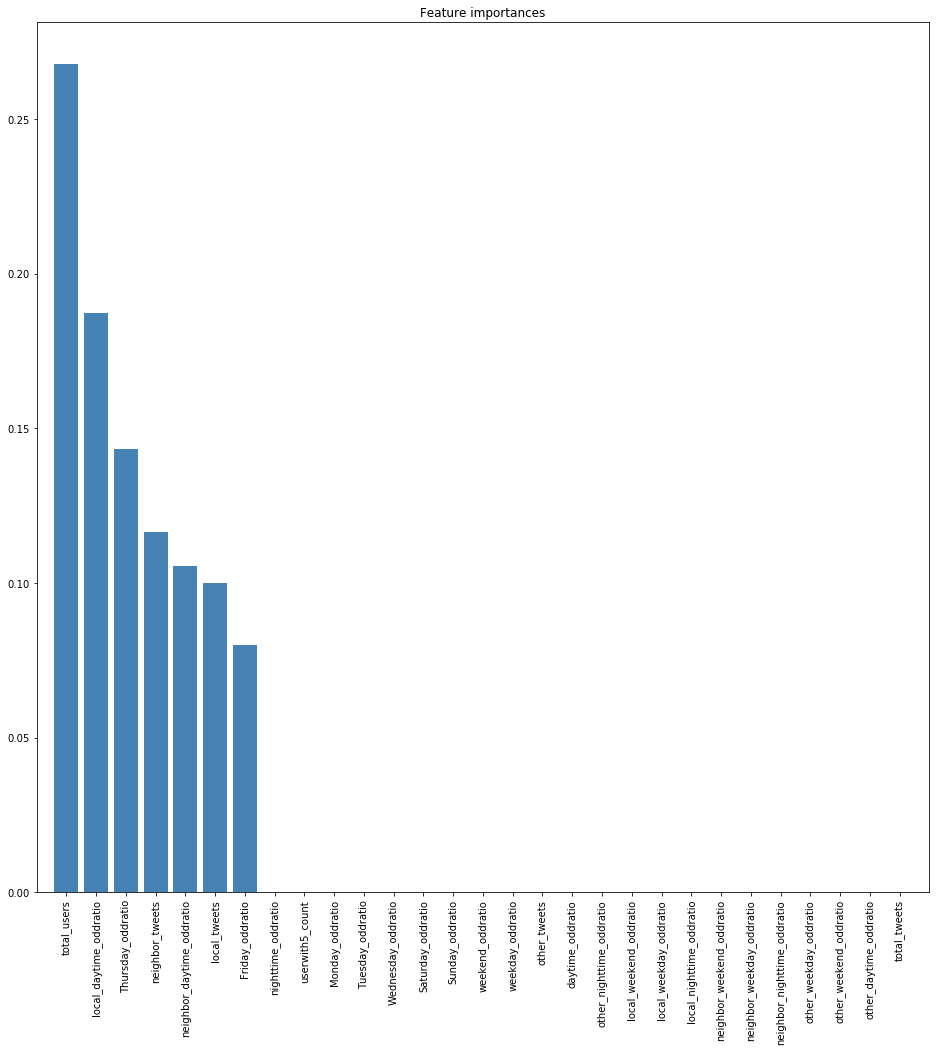

people_target trainscore:  0.870393900889 testscore:  0.852912142152 F1:  0.278922345483 
 [[2831   96]
 [ 359   88]]


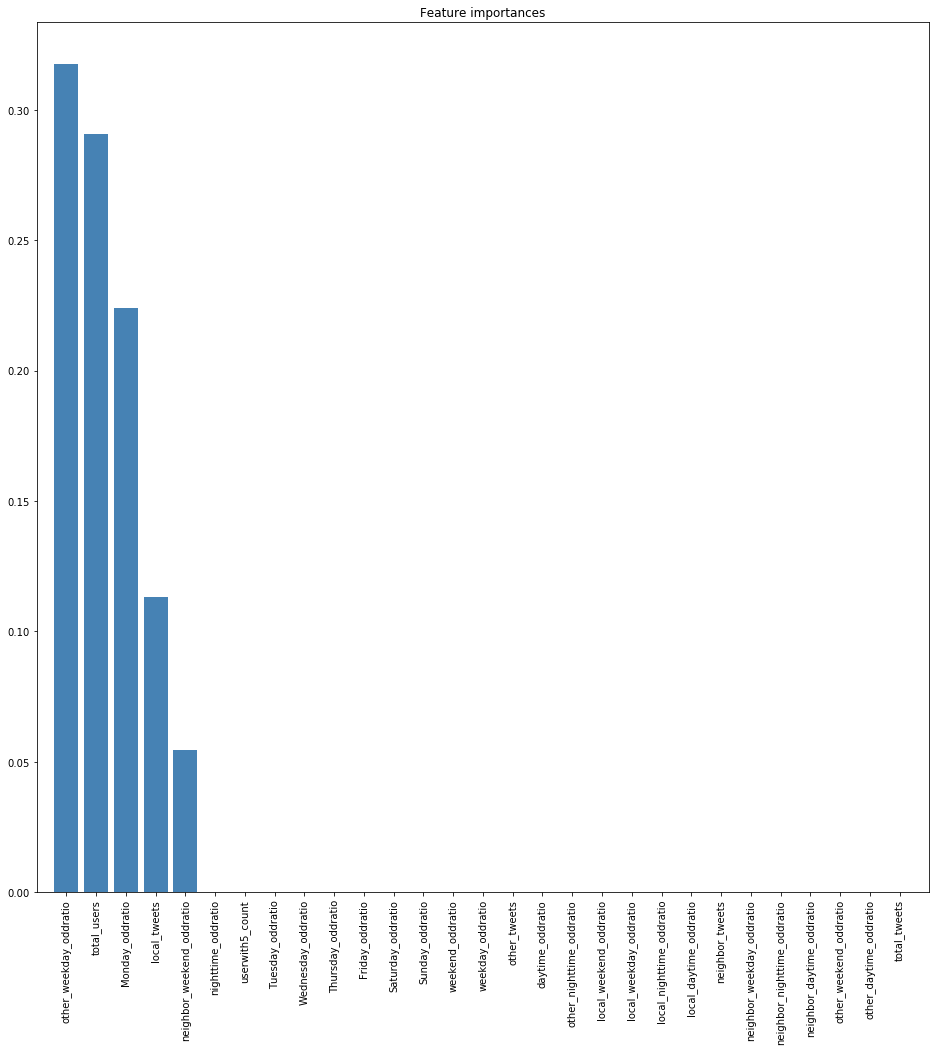

place1_target trainscore:  0.882253282507 testscore:  0.8923988154 F1:  0.0102301790281 
 [[2985    0]
 [ 387    2]]


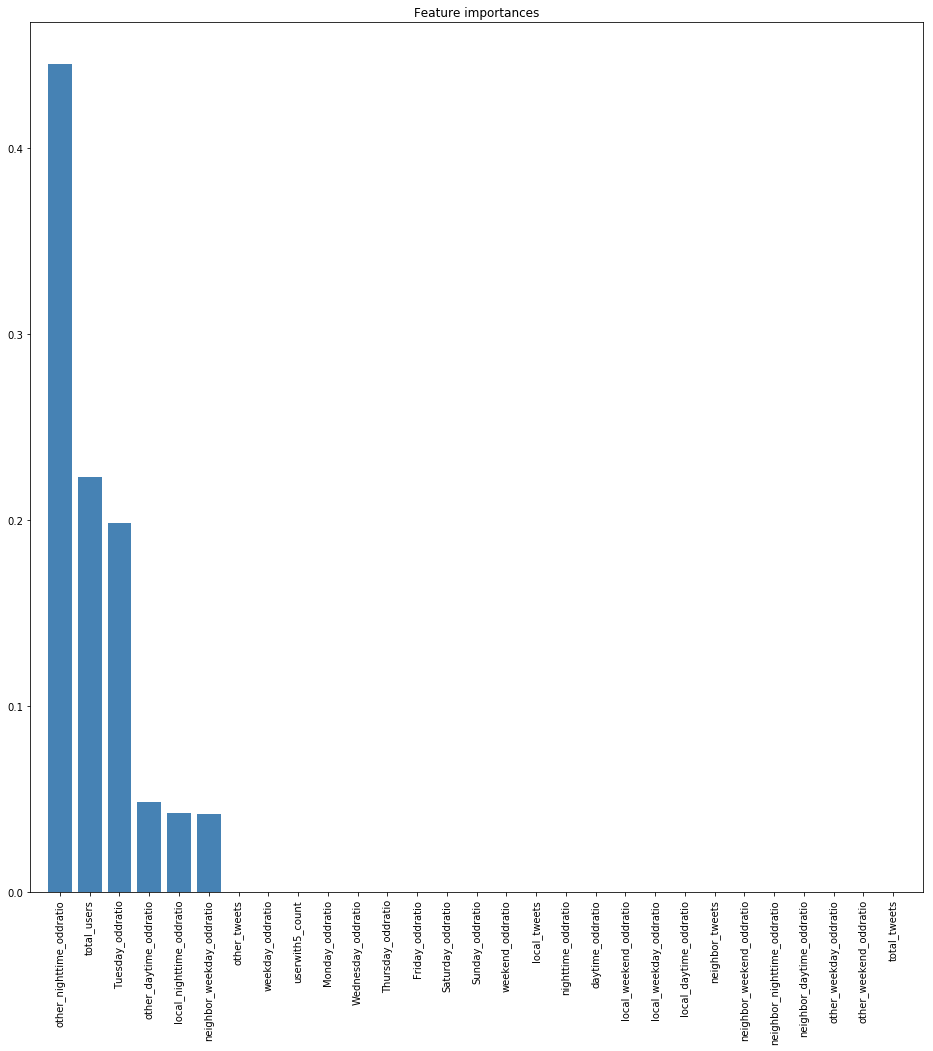

place2_target trainscore:  0.782719186785 testscore:  0.790720631787 F1:  0.878742264593 
 [[  22  703]
 [  22 2627]]


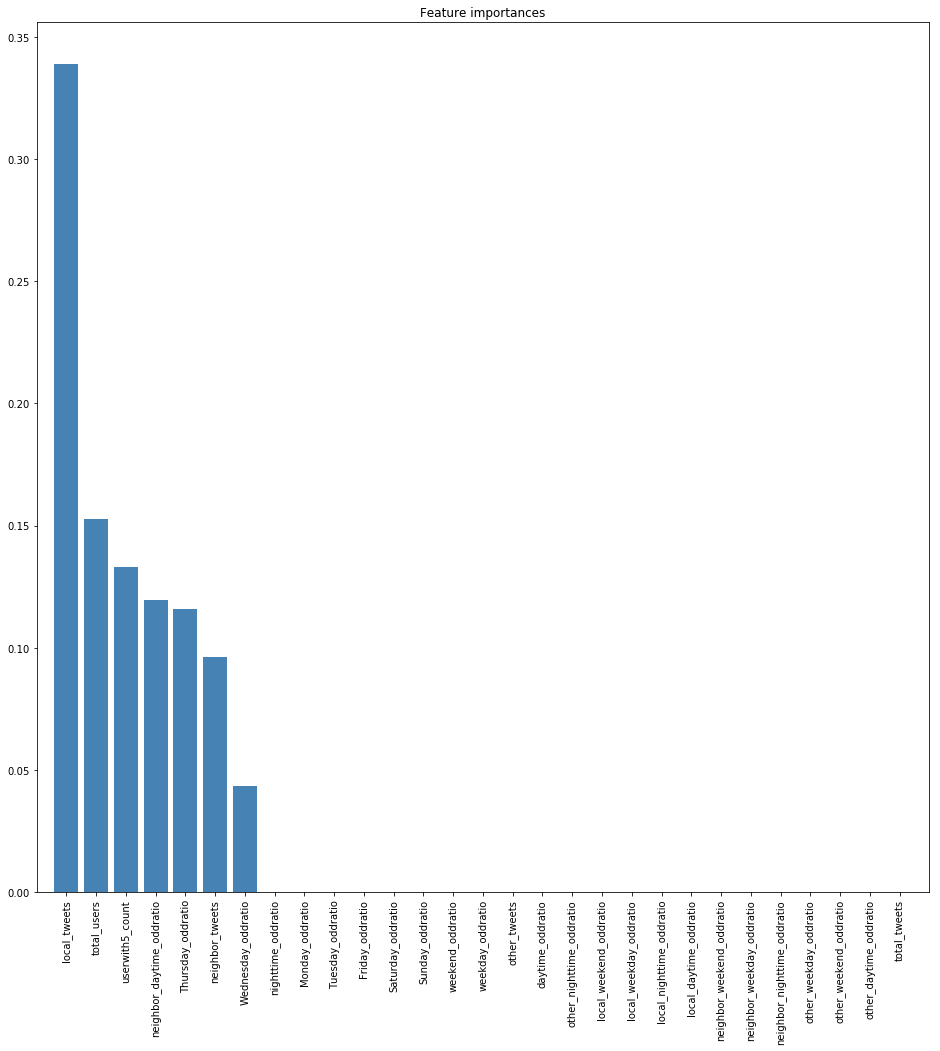

gent16_target trainscore:  0.945785684032 testscore:  0.938795656466 F1:  0.0594059405941 
 [[3178    3]
 [ 187    6]]


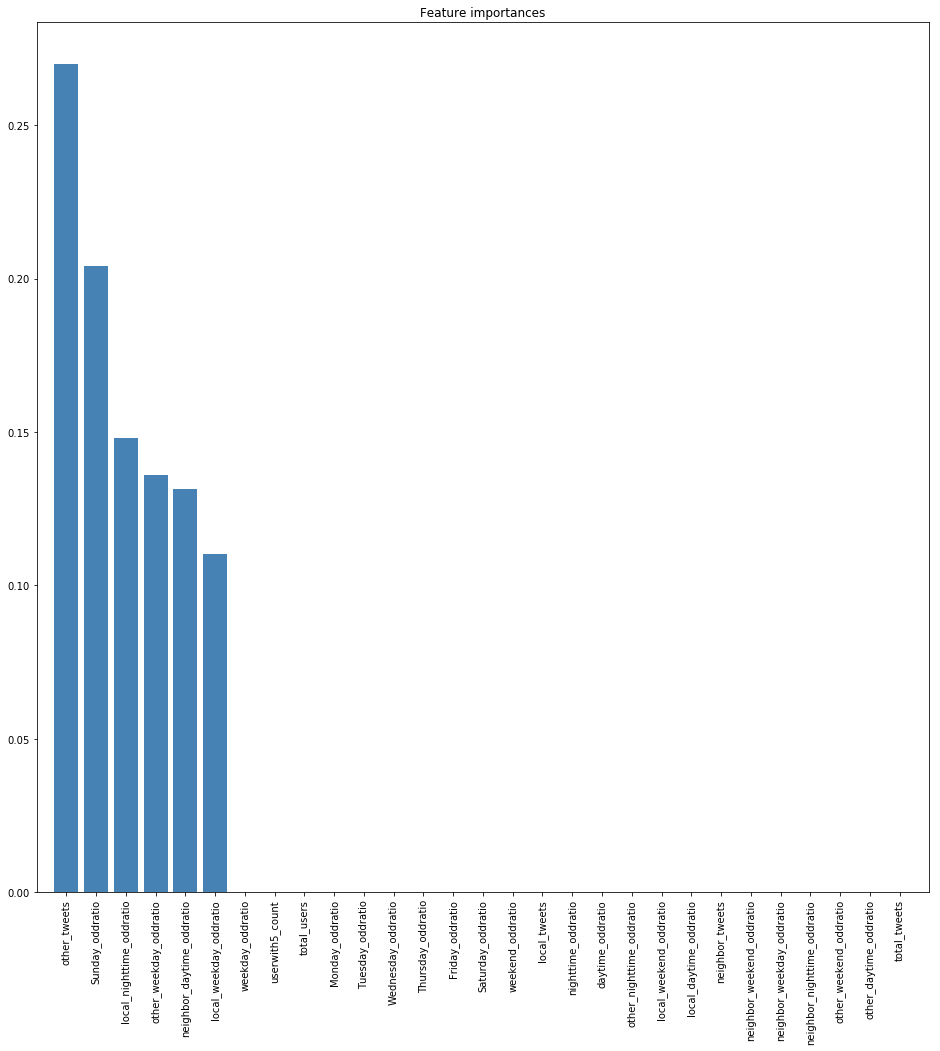

supergent_target trainscore:  0.977128335451 testscore:  0.966436327739 F1:  0.063829787234 
 [[3283    4]
 [  84    3]]


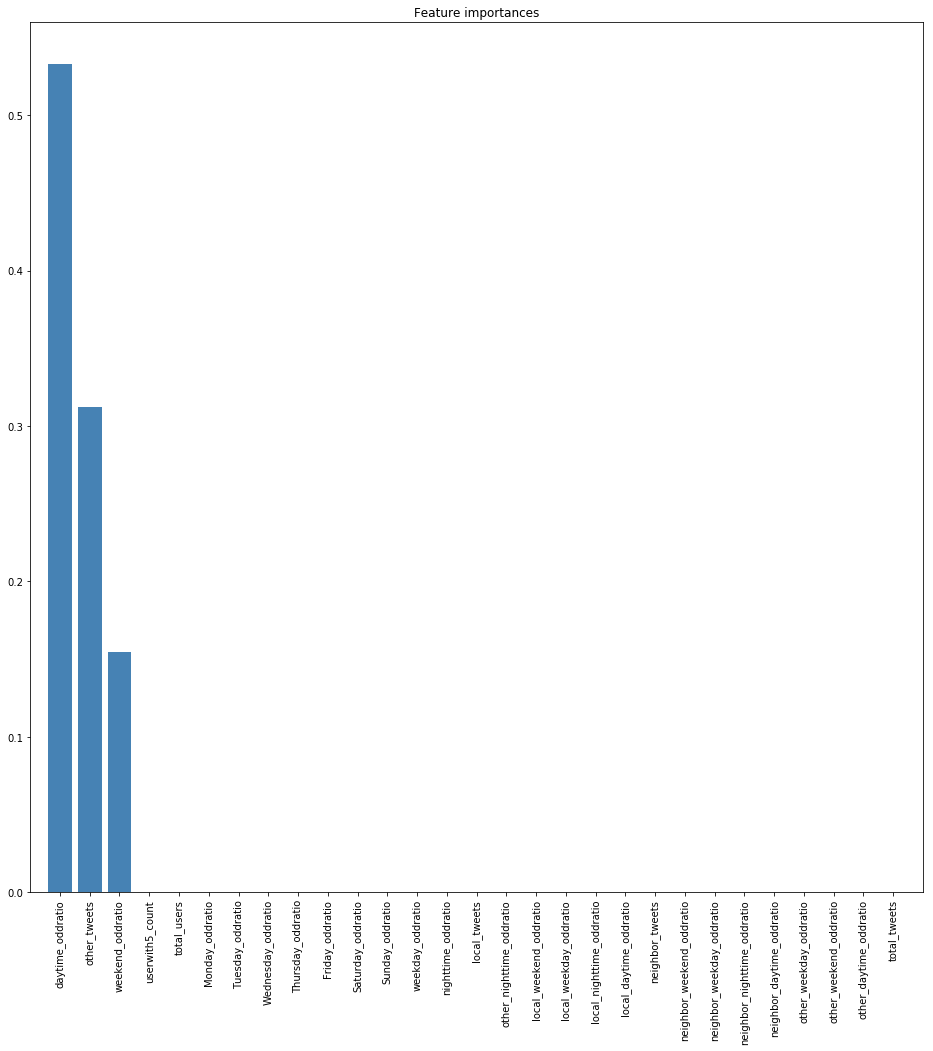

In [42]:
#targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
#targets = [full[['Type_binary']], full[['pct_ch_hinc00_16_binary']], full[['pct_ch_medhval00_16_binary']], full[['pct_ch_medrent00_16_binary']], full[['gent00_16_y']], full[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targets1: 
    modeldata1= binary_subset
    modeltarget1 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata1, modeltarget1, test_size = 0.3, random_state = 1)
    clf =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf.score(modeldata_train, modeltarget_train)
    testscore = clf.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget1, clf.predict(modeldata1))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n' , metrics.confusion_matrix(modeltarget1, clf.predict(modeldata1)))
    featureImportancePlot(clf, modeldata1.columns)
    a += 1

## Building a more robust model by adding census and other features to reduce the number of FN results and improve the number of TP results

In [43]:
#list(full.columns)

In [54]:
censussubset = full[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent90',
 'medrent00',
 'medhval00',
 'percol90',
 'percol00',
 'pernwh90',
 'pernwh00',
 'vulnrisk90',
 'vuln90',
 'afford00',
 'hinc90',
 'hinc00', 
  'Type_binary',
 'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [55]:
censussubset.shape

(3374, 50)

In [56]:
censussubset=censussubset.dropna()

In [57]:
censussubset.iloc[:, 0:-6]

,total_tweets,userwith5_count,total_users,Monday_oddratio,Tuesday_oddratio,Wednesday_oddratio,Thursday_oddratio,Friday_oddratio,Saturday_oddratio,Sunday_oddratio,...,medhval00,percol90,percol00,pernwh90,pernwh00,vulnrisk90,vuln90,afford00,hinc90,hinc00
0,58602,1100,4767,0.144398,0.144620,0.148050,0.142862,0.142094,0.133835,0.144142,...,2.739000e+05,0.238695,0.231504,0.061852,0.072632,0.0,0.0,1.0,117964.294603,120523.998898
1,61747,810,3917,0.152639,0.159668,0.146096,0.151473,0.130516,0.126727,0.132881,...,1.926000e+05,0.165695,0.155385,0.074755,0.212597,1.0,0.0,1.0,74405.970267,72720.400000
2,12882,257,1214,0.138643,0.151917,0.129405,0.134063,0.136004,0.158361,0.151374,...,1.607308e+05,0.119636,0.132740,0.088223,0.228813,0.0,0.0,1.0,70689.309942,73386.248102
3,5277,115,578,0.139473,0.124503,0.158234,0.165245,0.138336,0.137768,0.136441,...,3.563000e+05,0.516854,0.284779,0.575952,0.617156,1.0,0.0,1.0,59220.630138,84320.400000
4,40040,522,1678,0.131319,0.129970,0.132293,0.137512,0.118906,0.162363,0.187637,...,1.737000e+05,0.097015,0.058760,0.717520,0.851364,1.0,1.0,1.0,41365.319526,42744.550000
5,12274,180,978,0.136793,0.138912,0.141437,0.129787,0.125713,0.160176,0.167183,...,1.406000e+05,0.111412,0.074184,0.961538,0.992935,1.0,1.0,1.0,47673.366755,38177.528180
6,38292,309,1337,0.134571,0.142197,0.148491,0.128748,0.129766,0.157291,0.158702,...,1.347000e+05,0.025304,0.077946,0.827902,0.852144,1.0,1.0,1.0,38888.791517,46405.381642
7,10205,168,649,0.147477,0.139931,0.143949,0.133170,0.135228,0.148163,0.152082,...,3.093000e+05,0.179956,0.453011,0.095293,0.235139,0.0,0.0,1.0,114475.654092,116736.600000
8,46735,353,3444,0.152177,0.141200,0.139103,0.134396,0.136557,0.144389,0.152134,...,9.570000e+04,0.441393,0.329490,0.192794,0.467258,1.0,0.0,1.0,76060.289806,76125.000000
9,8020,136,551,0.165087,0.138030,0.143516,0.119327,0.132668,0.146758,0.154613,...,2.493000e+05,0.166143,0.388082,0.089913,0.297684,0.0,0.0,1.0,78986.459424,72961.099630


In [58]:
censusmodeldata=censussubset.iloc[:, 0:-6]
censusmodeltarget=censussubset.iloc[:,-6:]

[TN, FP][FN, TP]
binary trainscore:  0.842105263158 testscore:  0.848303393214 F1:  0.302543507363 
 [[2705   11]
 [ 510  113]]


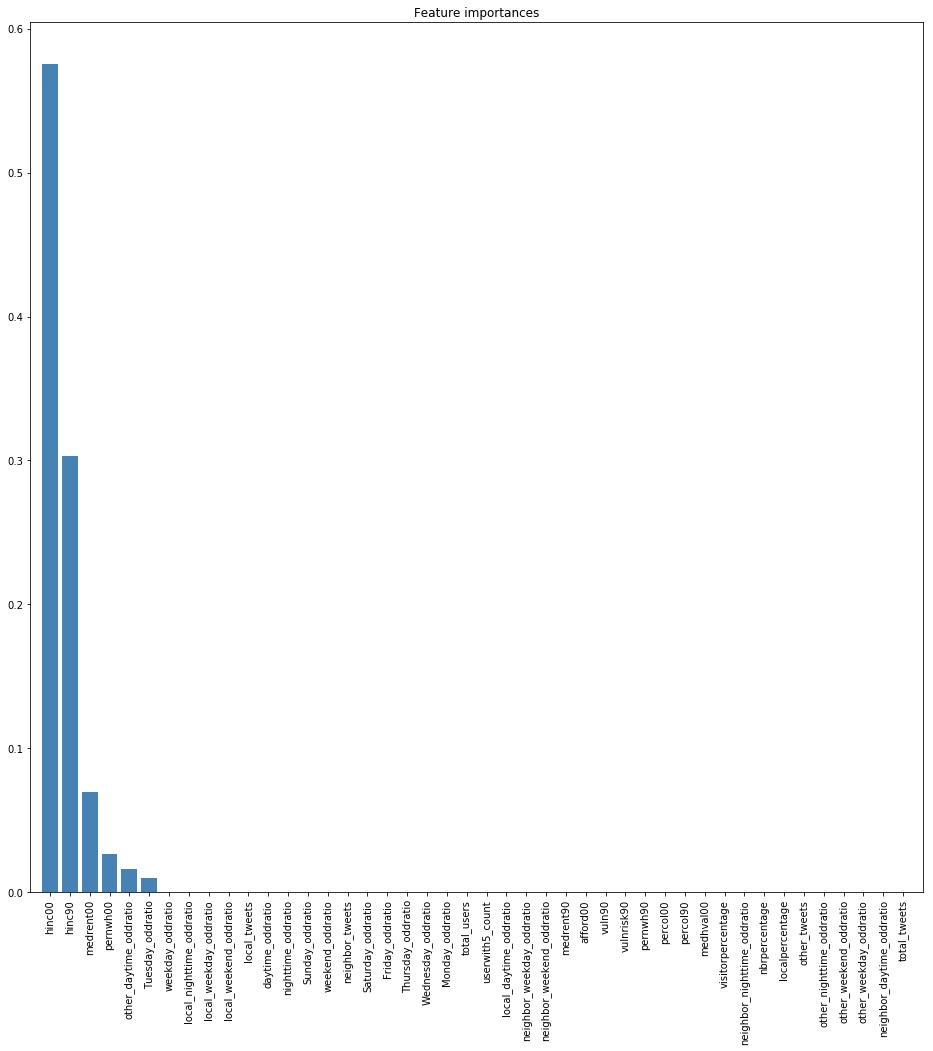

people_target trainscore:  0.879760376551 testscore:  0.872255489022 F1:  0.3456 
 [[2822   78]
 [ 331  108]]


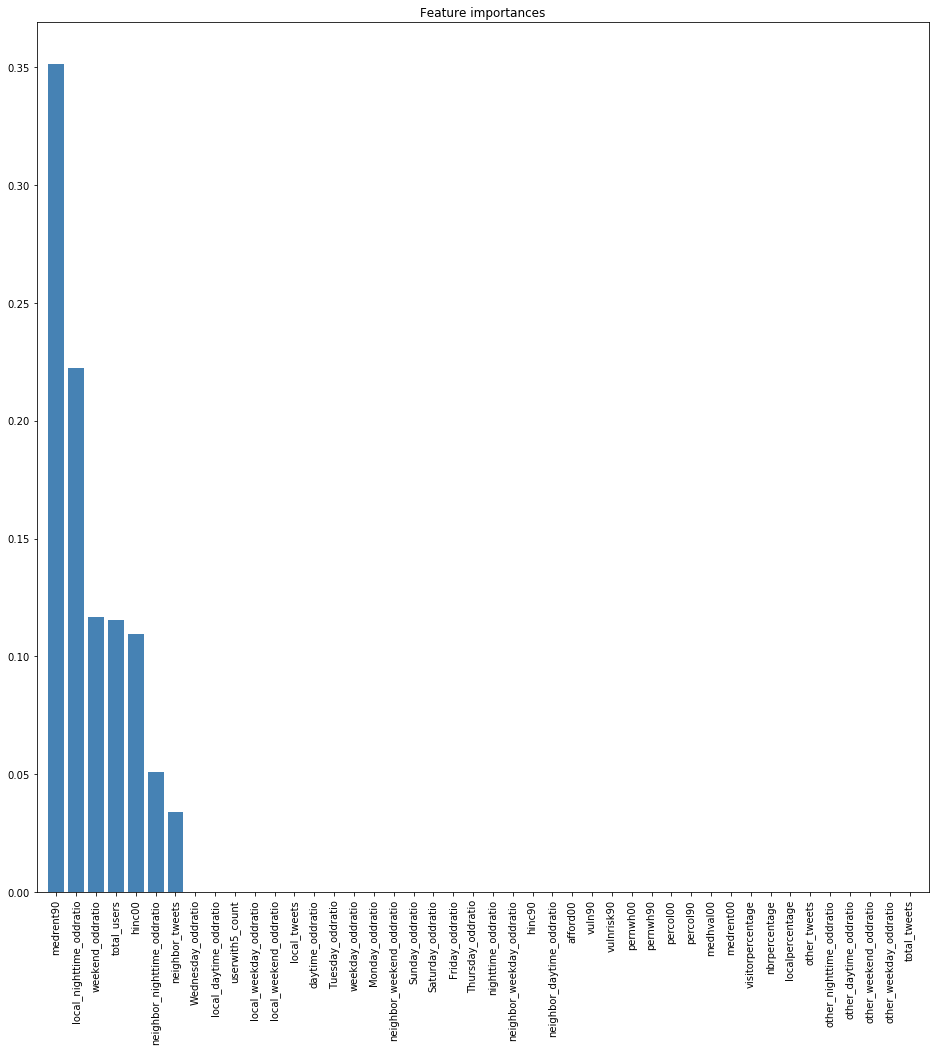

place1_target trainscore:  0.905862216517 testscore:  0.883233532934 F1:  0.37707948244 
 [[2900   53]
 [ 284  102]]


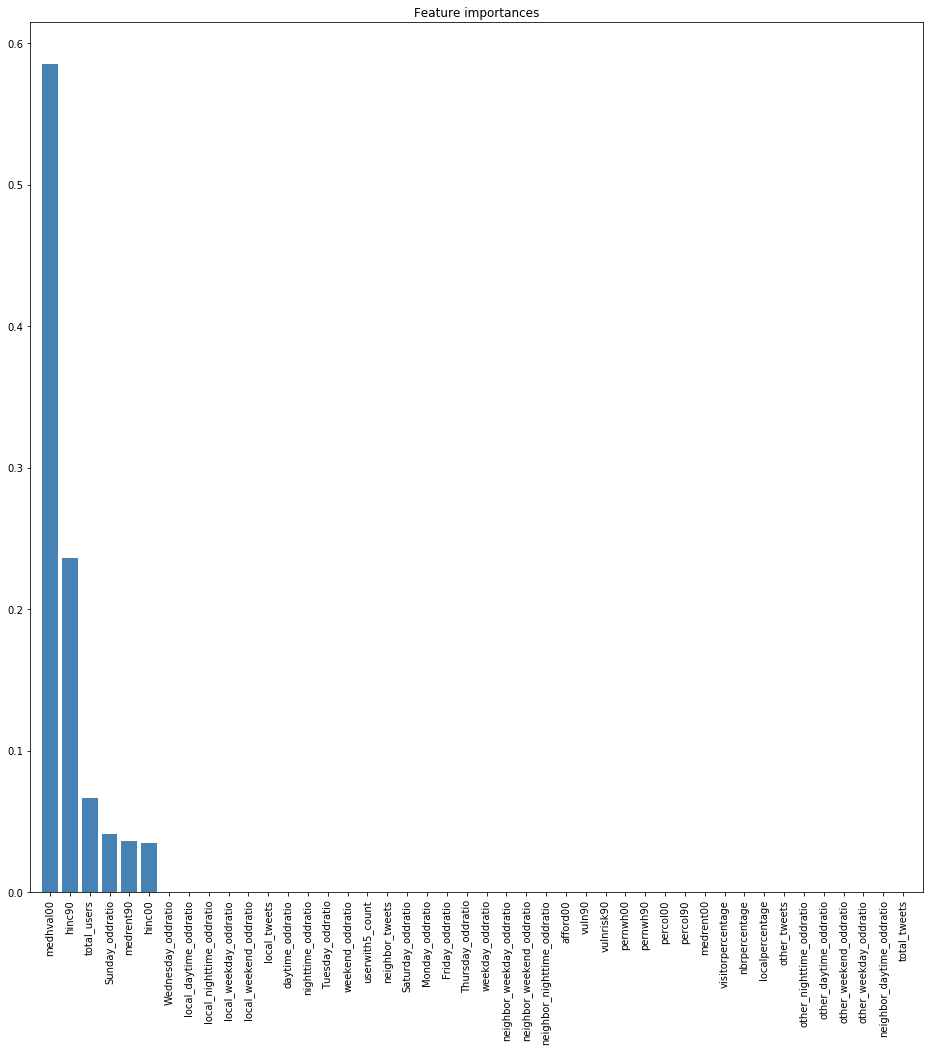

place2_target trainscore:  0.809584937955 testscore:  0.800399201597 F1:  0.884594739667 
 [[ 222  494]
 [ 151 2472]]


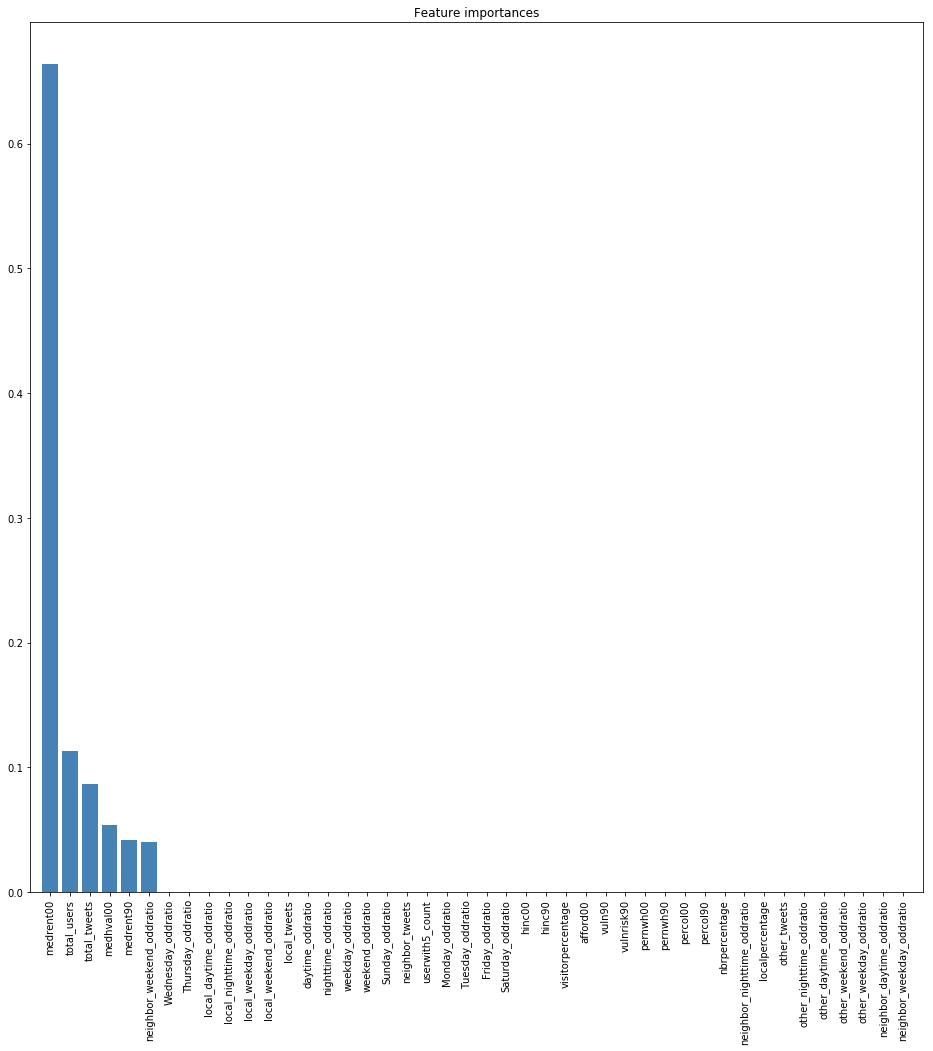

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


gent16_target trainscore:  0.940094137783 testscore:  0.948103792415 F1:  0.0 
 [[3147    0]
 [ 192    0]]


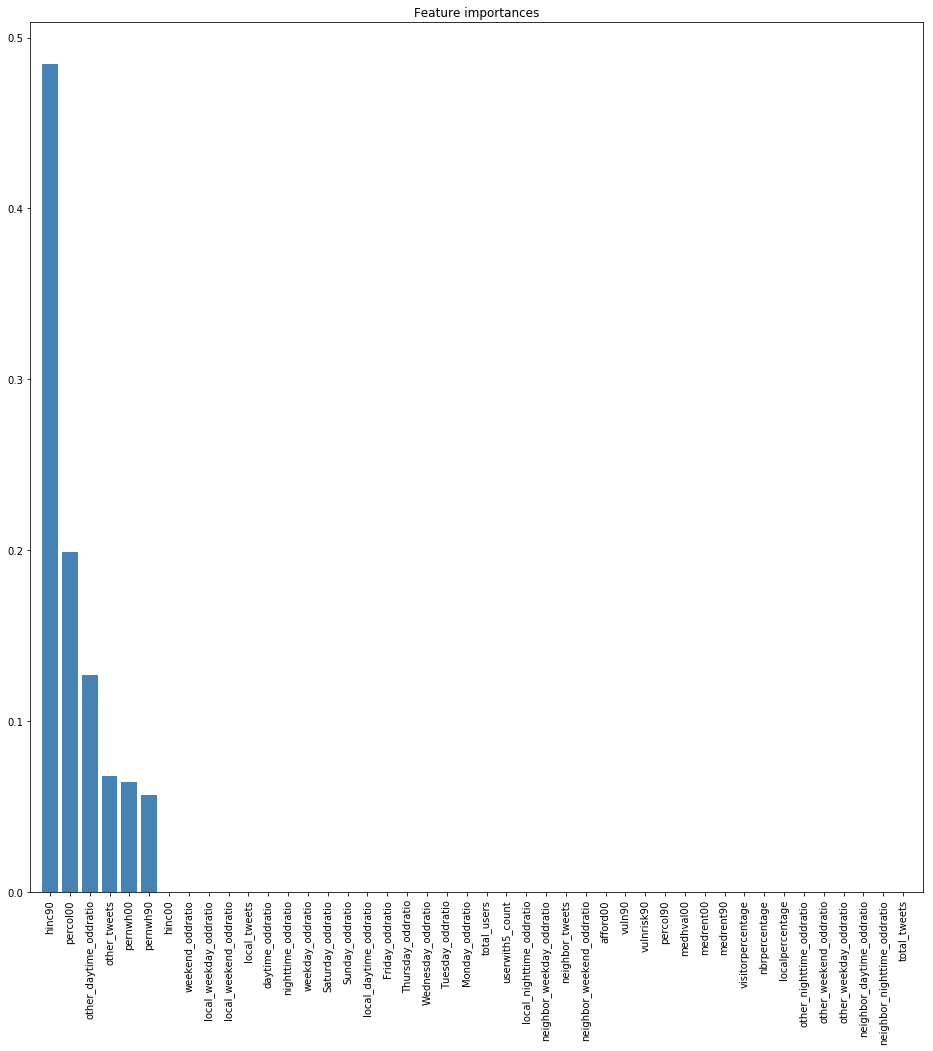

supergent_target trainscore:  0.985879332478 testscore:  0.987025948104 F1:  0.741573033708 
 [[3227   30]
 [  16   66]]


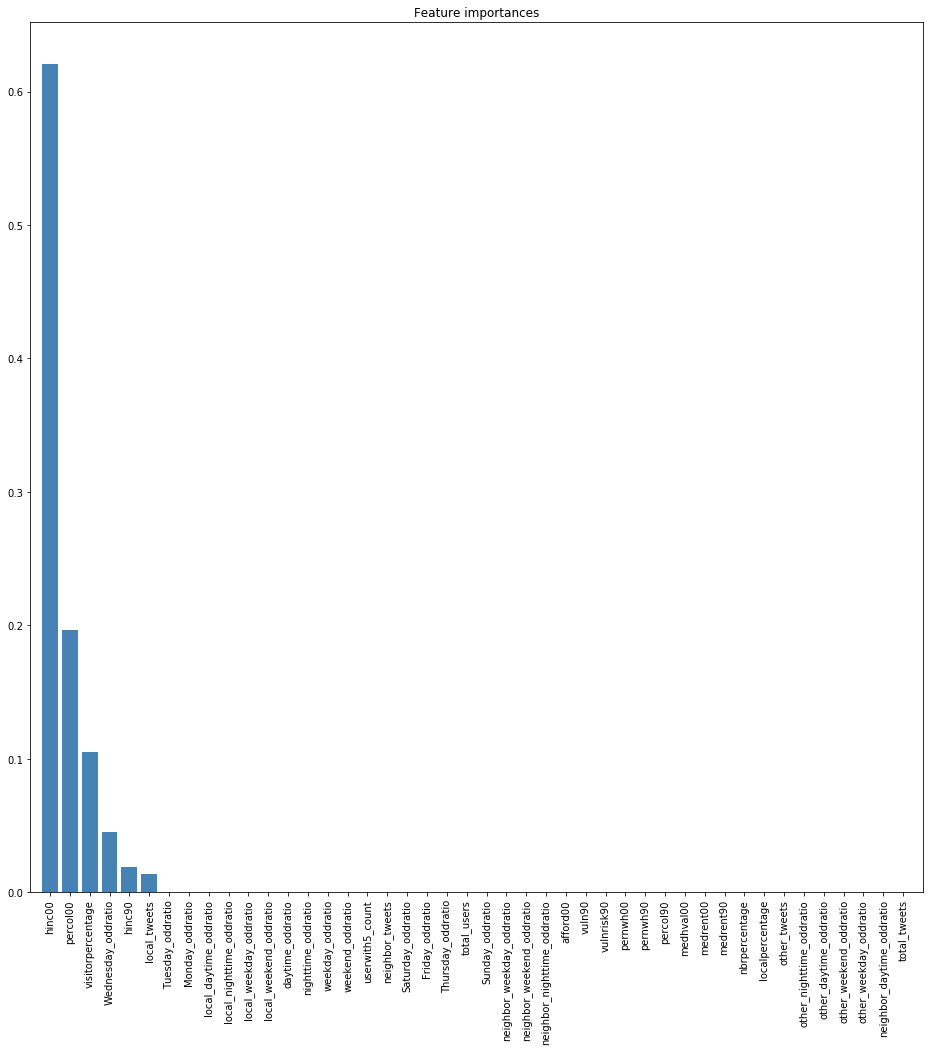

In [59]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    clf2 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf2.score(modeldata_train, modeltarget_train)
    testscore = clf2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget2, clf2.predict(modeldata2))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, clf2.predict(modeldata2)) )
    featureImportancePlot(clf2, modeldata2.columns)
    a += 1

In [71]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    logit_2 = LogisticRegression(C = 10000)
    logit_2.fit(modeldata_train, modeltarget_train)
    trainscore = logit_2.score(modeldata_train, modeltarget_train)
    testscore = logit_2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget2, logit_2.predict(modeldata2))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, logit_2.predict(modeldata2)) )
   # featureImportancePlot(logit_2, modeldata2.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.816431322208 testscore:  0.824351297405 F1:  0.190093708166 
 [[2663   53]
 [ 552   71]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

people_target trainscore:  0.865639709029 testscore:  0.870259481038 F1:  0.136186770428 
 [[2860   40]
 [ 404   35]]
place1_target trainscore:  0.893025246042 testscore:  0.887225548902 F1:  0.198675496689 
 [[2931   22]
 [ 341   45]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place2_target trainscore:  0.778348309799 testscore:  0.774451097804 F1:  0.870967741935 
 [[  84  632]
 [ 112 2511]]
gent16_target trainscore:  0.93838254172 testscore:  0.946107784431 F1:  0.01 
 [[3140    7]
 [ 191    1]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

supergent_target trainscore:  0.96919127086 testscore:  0.977045908184 F1:  0.251968503937 
 [[3228   29]
 [  66   16]]


# THE BELOW RF MODELS COULD PROBABLY BE TUNED

In [78]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets2 = [censussubset[['Type_binary']], censussubset[['pct_ch_hinc00_16_binary']], censussubset[['pct_ch_medhval00_16_binary']], censussubset[['pct_ch_medrent00_16_binary']], censussubset[['gent00_16_y']], censussubset[['Supergent16']]]
a=0 
print('[TN, FP][FN, TP]')
seed = 5
for n in targets2: 
    modeldata2= censusmodeldata
    modeltarget2 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata2, modeltarget2, test_size = 0.3, random_state = 1)
    param_grid = {'max_depth':range(1,11),'n_estimators':range(1,11),'max_leaf_nodes':range(2,11)}
    rf2=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf2 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf2.fit(modeldata_train, modeltarget_train)
    trainscore = rf2.score(modeldata_train, modeltarget_train)
    testscore = rf2.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget2, rf2.predict(modeldata2))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget2, logit_2.predict(modeldata2)) )
   # featureImportancePlot(rf2, modeldata2.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.838254172015 testscore:  0.844311377246 F1:  0.278378378378 
 [[2699   17]
 [ 595   28]]
people_target trainscore:  0.870346598203 testscore:  0.878243512974 F1:  0.0700218818381 
 [[2856   44]
 [ 438    1]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

place1_target trainscore:  0.888746255884 testscore:  0.879241516966 F1:  0.0403022670025 
 [[2909   44]
 [ 385    1]]
place2_target trainscore:  0.813436029097 testscore:  0.804391217565 F1:  0.890201528839 
 [[ 699   17]
 [2595   28]]
gent16_target trainscore:  0.940094137783 testscore:  0.948103792415 F1:  0.0 
 [[3105   42]
 [ 189    3]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array 

supergent_target trainscore:  0.983311938383 testscore:  0.983033932136 F1:  0.5 
 [[3228   29]
 [  66   16]]


# Incorporating Distance features

Distance features to high visitor tracts, high tweet tract, and high income neighborhoods were added based on the findings in our literature review and data exploration

In [62]:
dist=pd.read_csv('Data/twitter_distance.csv', index_col=0)

In [63]:
dist.columns

Index(['geoid', 'distToHighVisitorTract', 'distToHighTweetTract', 'distToMHI'], dtype='object')

In [64]:
withdist=full.merge(dist, right_on='geoid', left_on='geojoin')

In [65]:
distdata=withdist[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent90',
 'medrent00',
 'medhval00',
 'percol90',
 'percol00',
 'pernwh90',
 'pernwh00',
 'vulnrisk90',
 'vuln90',
 'afford00',
 'hinc90',
 'hinc00',
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16']]

In [66]:
distdata = distdata.dropna()

[TN, FP][FN, TP]
binary trainscore:  0.855913978495 testscore:  0.826479438315 F1:  0.422727272727 
 [[2628   78]
 [ 430  186]]


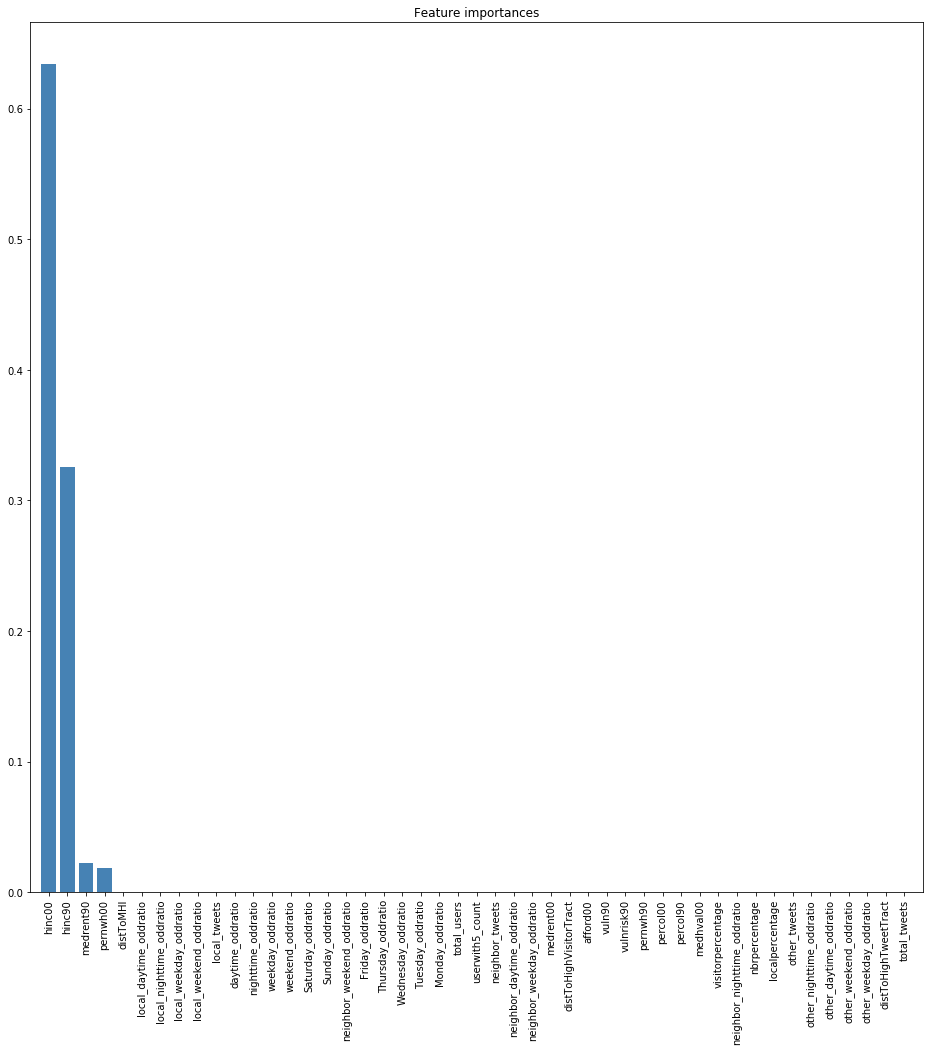

people_target trainscore:  0.880860215054 testscore:  0.882647943831 F1:  0.291366906475 
 [[2847   37]
 [ 357   81]]


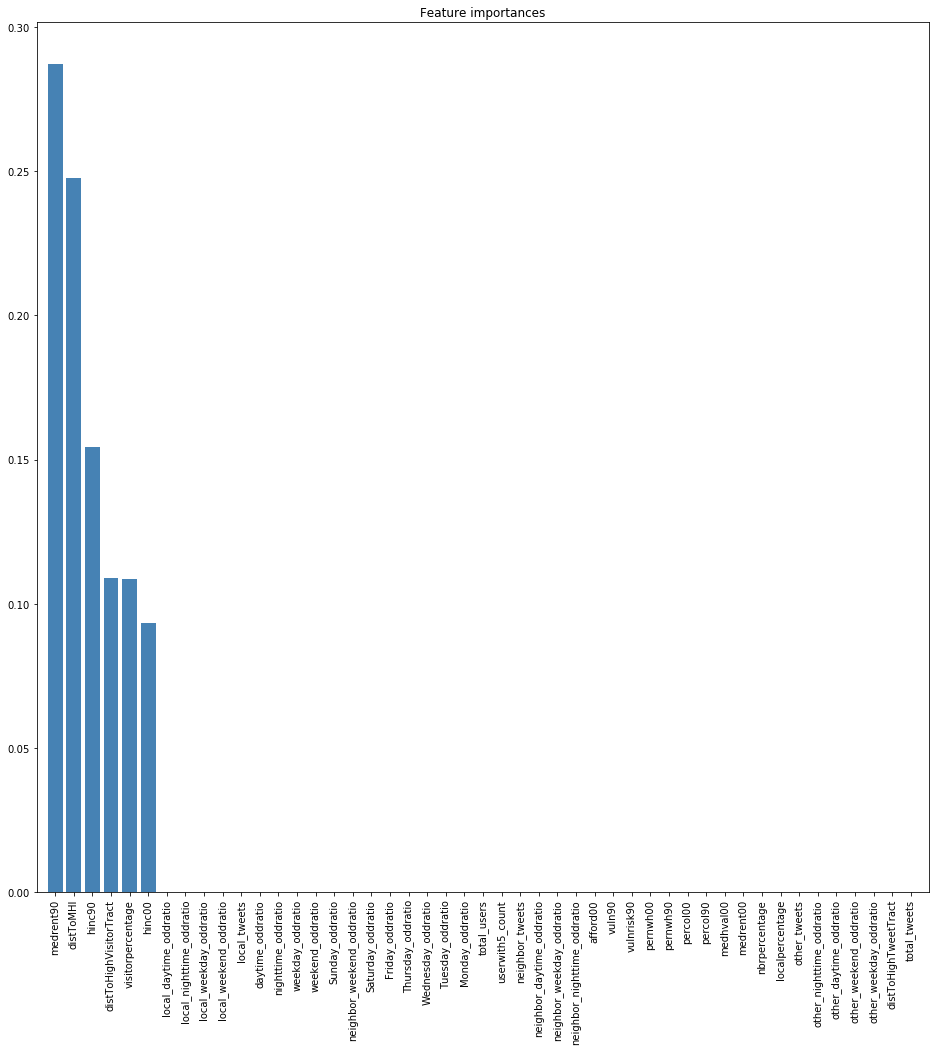

place1_target trainscore:  0.907956989247 testscore:  0.88665997994 F1:  0.493023255814 
 [[2836  100]
 [ 227  159]]


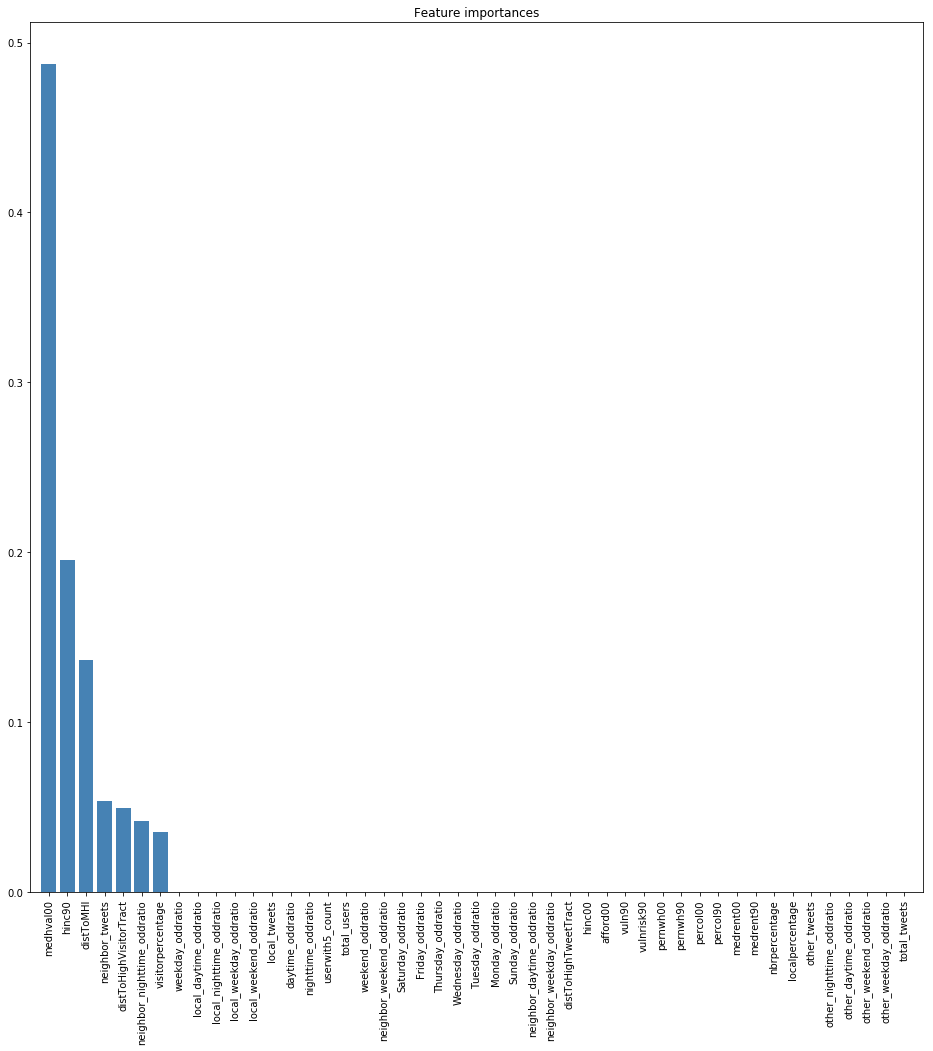

place2_target trainscore:  0.824086021505 testscore:  0.791374122367 F1:  0.890272096746 
 [[ 202  504]
 [ 113 2503]]


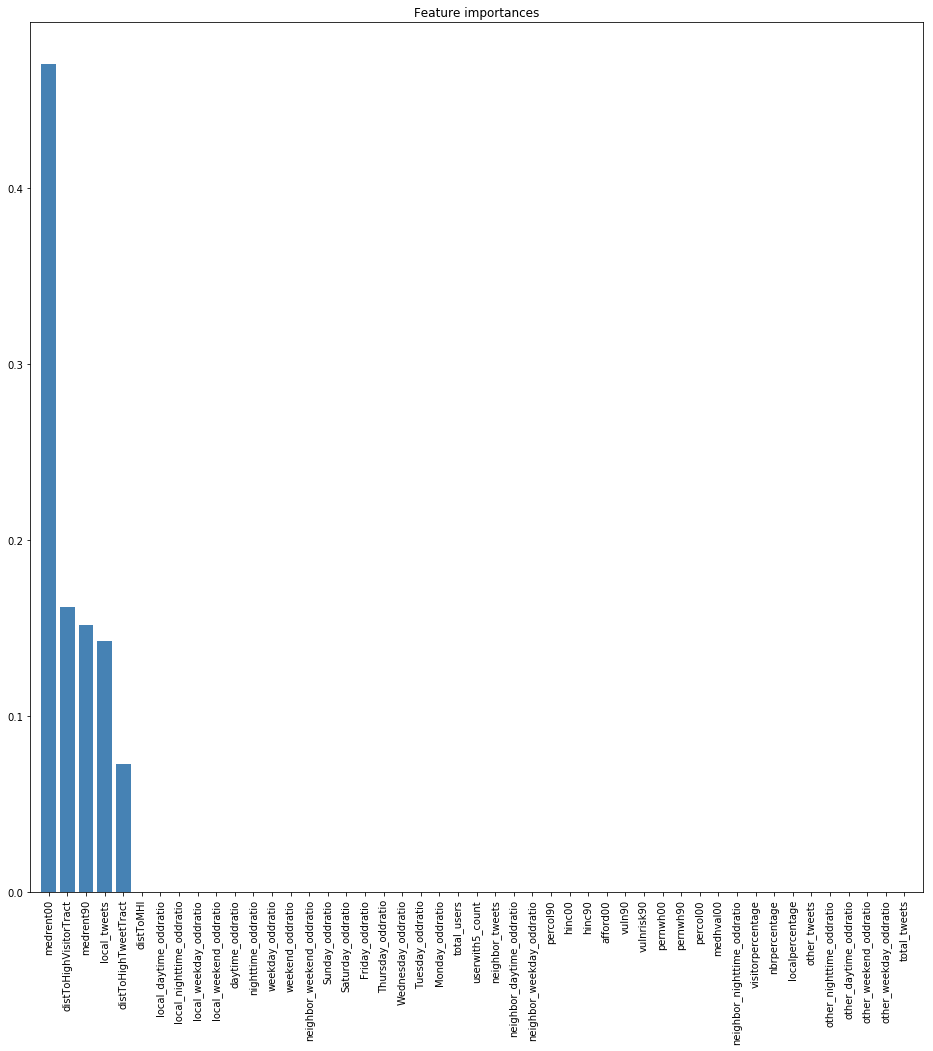

gent16_target trainscore:  0.950967741935 testscore:  0.92778335005 F1:  0.0510204081633 
 [[3131    0]
 [ 186    5]]


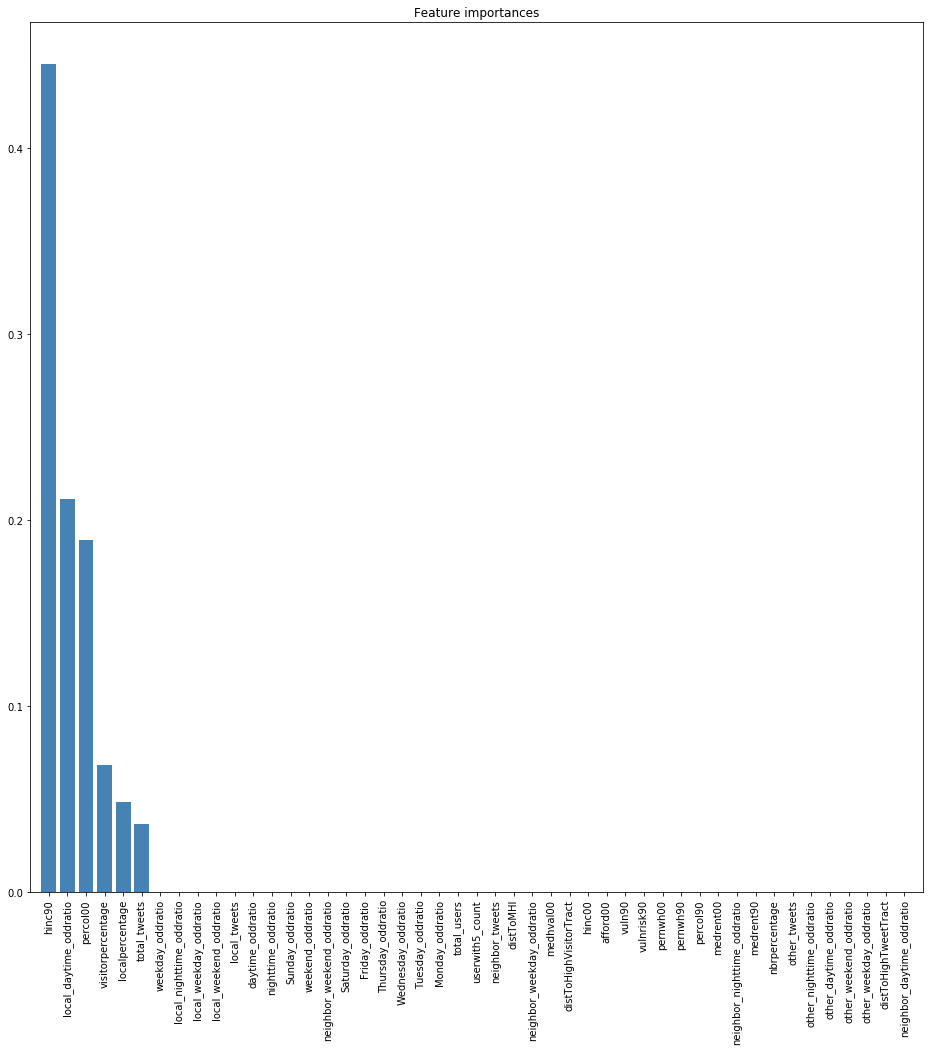

supergent_target trainscore:  0.989247311828 testscore:  0.983951855567 F1:  0.765714285714 
 [[3214   29]
 [  12   67]]


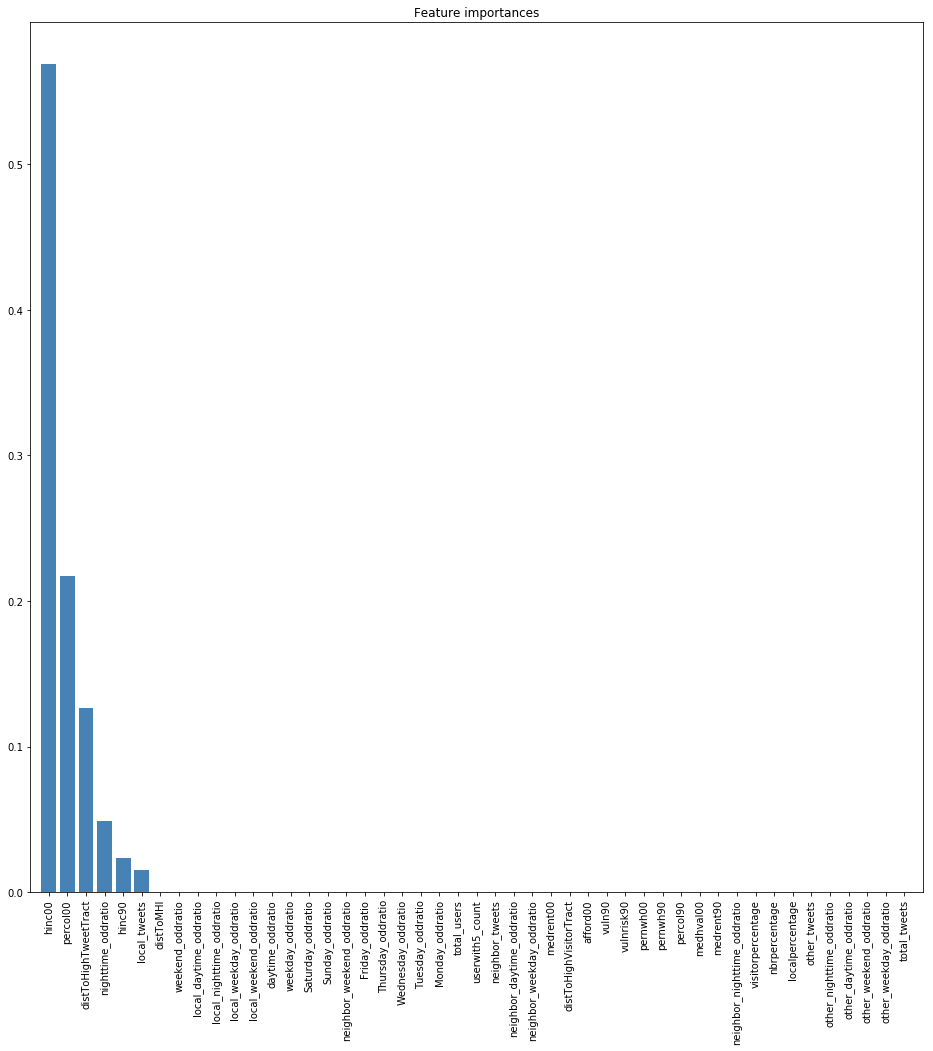

In [67]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    clf3 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf3.score(modeldata_train, modeltarget_train)
    testscore = clf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, clf3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, clf3.predict(modeldata3)) )
    featureImportancePlot(clf3, modeldata3.columns)
    a += 1

In [80]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    logit_3 = LogisticRegression(C = 10000)
    logit_3.fit(modeldata_train, modeltarget_train)
    trainscore = logit_3.score(modeldata_train, modeltarget_train)
    testscore = logit_3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, logit_3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, logit_3.predict(modeldata3)) )
    #featureImportancePlot(logit_3, modeldata3.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.81935483871 testscore:  0.812437311936 F1:  0.178619756428 
 [[2649   57]
 [ 550   66]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

people_target trainscore:  0.865376344086 testscore:  0.872617853561 F1:  0.153846153846 
 [[2842   42]
 [ 398   40]]
place1_target trainscore:  0.885161290323 testscore:  0.900702106319 F1:  0.227848101266 
 [[2902   34]
 [ 332   54]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place2_target trainscore:  0.78064516129 testscore:  0.772316950853 F1:  0.872159583695 
 [[  71  635]
 [ 102 2514]]
gent16_target trainscore:  0.94752688172 testscore:  0.924774322969 F1:  0.0100502512563 
 [[3124    7]
 [ 190    1]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

supergent_target trainscore:  0.973333333333 testscore:  0.966900702106 F1:  0.128440366972 
 [[3220   23]
 [  72    7]]


In [81]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets3 = [distdata[['Type_binary']], distdata[['pct_ch_hinc00_16_binary']], distdata[['pct_ch_medhval00_16_binary']], distdata[['pct_ch_medrent00_16_binary']], distdata[['gent00_16_y']], distdata[['Supergent16']]]
distmodeldata = distdata.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets3: 
    modeldata3= distmodeldata
    modeltarget3 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata3, modeltarget3, test_size = 0.3, random_state = 1)
    rf3=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf3 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf3.fit(modeldata_train, modeltarget_train)
    trainscore = rf3.score(modeldata_train, modeltarget_train)
    testscore = rf3.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget3, rf3.predict(modeldata3))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n', metrics.confusion_matrix(modeltarget3, rf3.predict(modeldata3)) )
   # featureImportancePlot(rf3, modeldata3.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.842150537634 testscore:  0.826479438315 F1:  0.243697478992 
 [[2695   11]
 [ 529   87]]
people_target trainscore:  0.87311827957 testscore:  0.883650952859 F1:  0.141962421712 
 [[2877    7]
 [ 404   34]]
place1_target trainscore:  0.880860215054 testscore:  0.902708124373 F1:  0.065 
 [[2935    1]
 [ 373   13]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

place2_target trainscore:  0.813333333333 testscore:  0.786359077232 F1:  0.88835202761 
 [[ 101  605]
 [  42 2574]]
gent16_target trainscore:  0.949247311828 testscore:  0.92778335005 F1:  0.0104166666667 
 [[3131    0]
 [ 190    1]]
supergent_target trainscore:  0.985806451613 testscore:  0.974924774323 F1:  0.42 
 [[3243    0]
 [  58   21]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

# Adding New Census Features like Age group, etc

In [83]:
newcensus = pd.read_csv('Data/DEC_10_SF1_QTP1_with_ann.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,3,4,5,10,11,12,17,18,19,24,25,26,31,32,33,38,39,40,45,46,47,52,53,54,59,60,61,66,67,68,73,74,75,80,81,82,87,88,89,94,95,96,101,102,103,108,109,110,115,116,117,122,123,124,129,130,131,136,137,138,143,144,145,150,151,152,157,158,159,164,165,166,171,172,173,178,179,180,185,186,187,192,193,194,199,200,201,206,207,208,213,214,215,220,221,222,227,228,229,234,235,236,241,242,243,248,249,250,255,256,257,262,263,264,269,270,271,276,277,278,283,284,285) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [84]:
newcensus.drop(newcensus.index[0:1], inplace=True)

In [85]:
list(newcensus.columns)

['GEO.id',
 'GEO.id2',
 'GEO.display-label',
 'SUBHD0101_S01',
 'SUBHD0102_S01',
 'SUBHD0103_S01',
 'SUBHD0201_S01',
 'SUBHD0202_S01',
 'SUBHD0203_S01',
 'HD03_S01',
 'SUBHD0101_S02',
 'SUBHD0102_S02',
 'SUBHD0103_S02',
 'SUBHD0201_S02',
 'SUBHD0202_S02',
 'SUBHD0203_S02',
 'HD03_S02',
 'SUBHD0101_S03',
 'SUBHD0102_S03',
 'SUBHD0103_S03',
 'SUBHD0201_S03',
 'SUBHD0202_S03',
 'SUBHD0203_S03',
 'HD03_S03',
 'SUBHD0101_S04',
 'SUBHD0102_S04',
 'SUBHD0103_S04',
 'SUBHD0201_S04',
 'SUBHD0202_S04',
 'SUBHD0203_S04',
 'HD03_S04',
 'SUBHD0101_S05',
 'SUBHD0102_S05',
 'SUBHD0103_S05',
 'SUBHD0201_S05',
 'SUBHD0202_S05',
 'SUBHD0203_S05',
 'HD03_S05',
 'SUBHD0101_S06',
 'SUBHD0102_S06',
 'SUBHD0103_S06',
 'SUBHD0201_S06',
 'SUBHD0202_S06',
 'SUBHD0203_S06',
 'HD03_S06',
 'SUBHD0101_S07',
 'SUBHD0102_S07',
 'SUBHD0103_S07',
 'SUBHD0201_S07',
 'SUBHD0202_S07',
 'SUBHD0203_S07',
 'HD03_S07',
 'SUBHD0101_S08',
 'SUBHD0102_S08',
 'SUBHD0103_S08',
 'SUBHD0201_S08',
 'SUBHD0202_S08',
 'SUBHD0203_S08',


In [86]:
newcensussubset = newcensus[['GEO.id2',
 'SUBHD0201_S06',
 'SUBHD0202_S06',
 'SUBHD0203_S06',
 'HD03_S06',
 'SUBHD0201_S07',
 'SUBHD0202_S07',
 'SUBHD0203_S07',
 'HD03_S07',
 'SUBHD0201_S08',
 'SUBHD0202_S08',
 'SUBHD0203_S08',
 'HD03_S08']]

In [87]:
#newcensussubset.to_csv('Data/agegroups2010NYC.csv')

In [88]:
withnewcen = withdist.merge(newcensussubset, right_on='GEO.id2', left_on='geoid_x')

In [89]:
nulls=withnewcen.columns[withnewcen.isnull().any()]

In [90]:
withnewcen[nulls].isnull().sum()

oddratio_8AM                 2
oddratio_10AM                2
local_oddratio_12AM          1
local_oddratio_2AM           1
local_oddratio_4AM           2
local_oddratio_5AM           2
local_oddratio_6AM           3
local_oddratio_7AM           7
local_oddratio_8AM          12
local_oddratio_9AM          19
local_oddratio_10AM         15
local_oddratio_11AM          7
local_oddratio_12PM          3
local_oddratio_1PM           1
local_oddratio_3PM           1
local_oddratio_5PM           1
local_oddratio_6PM           2
local_oddratio_7PM           1
local_oddratio_8PM           2
local_oddratio_9PM           2
local_Tuesday_oddratio       1
local_Saturday_oddratio      1
medrent90                    4
medrent16                   12
medhval90                  114
medhval00                   18
medhval16                   81
hinc90_NYU                 141
hinc00_NYU                 141
hinc16_NYU                 141
per_limove16                 5
per_limove09                 7
exclusio

In [91]:
withnewcen.shape

(1167, 249)

In [92]:
withnewcen = withnewcen[~withnewcen['SUBHD0201_S06'].str.contains('X')]

In [93]:
withnewcen = withnewcen.dropna()

In [94]:
withnewcenmodel = withnewcen[[ 'total_tweets',
 'userwith5_count',
 'total_users',
 'Monday_oddratio',
 'Tuesday_oddratio',
 'Wednesday_oddratio',
 'Thursday_oddratio',
 'Friday_oddratio',
 'Saturday_oddratio',
 'Sunday_oddratio',
 'weekend_oddratio',
 'weekday_oddratio',
 'nighttime_oddratio',
 'daytime_oddratio',
 'local_tweets',
  'local_weekend_oddratio',
  'local_weekday_oddratio',
  'local_nighttime_oddratio',
  'local_daytime_oddratio',
 'neighbor_tweets',
 'neighbor_weekend_oddratio',
 'neighbor_weekday_oddratio',
 'neighbor_nighttime_oddratio',
 'neighbor_daytime_oddratio',
 'other_weekday_oddratio',
 'other_weekend_oddratio',
 'other_daytime_oddratio',
 'other_nighttime_oddratio',
 'other_tweets',
 ## Adding percentage metrics
 'localpercentage',
 'nbrpercentage',
 'visitorpercentage',
## Adding census features
 'medrent90',
 'medrent00',
 'medhval00',
 'percol90',
 'percol00',
 'pernwh90',
 'pernwh00',
 'vulnrisk90',
 'vuln90',
 'afford00',
 'hinc90',
 'hinc00',
 #'Type_binary',
  'distToHighVisitorTract', 
  'distToHighTweetTract', 
  'distToMHI',
   'SUBHD0201_S06',
 'SUBHD0202_S06',
 'SUBHD0203_S06',
 #'HD03_S06',
 'SUBHD0201_S07',
 'SUBHD0202_S07',
 'SUBHD0203_S07',
 #'HD03_S07',
 'SUBHD0201_S08',
 'SUBHD0202_S08',
 'SUBHD0203_S08',
 #'HD03_S08'
  'Type_binary',
  'pct_ch_hinc00_16_binary',
 'pct_ch_medhval00_16_binary',
 'pct_ch_medrent00_16_binary',
 'gent00_16_y',
 'Supergent16'
   ]]

[TN, FP][FN, TP]
binary trainscore:  0.87091222031 testscore:  0.82 F1:  0.53488372093 
 [[642  26]
 [ 94  69]]


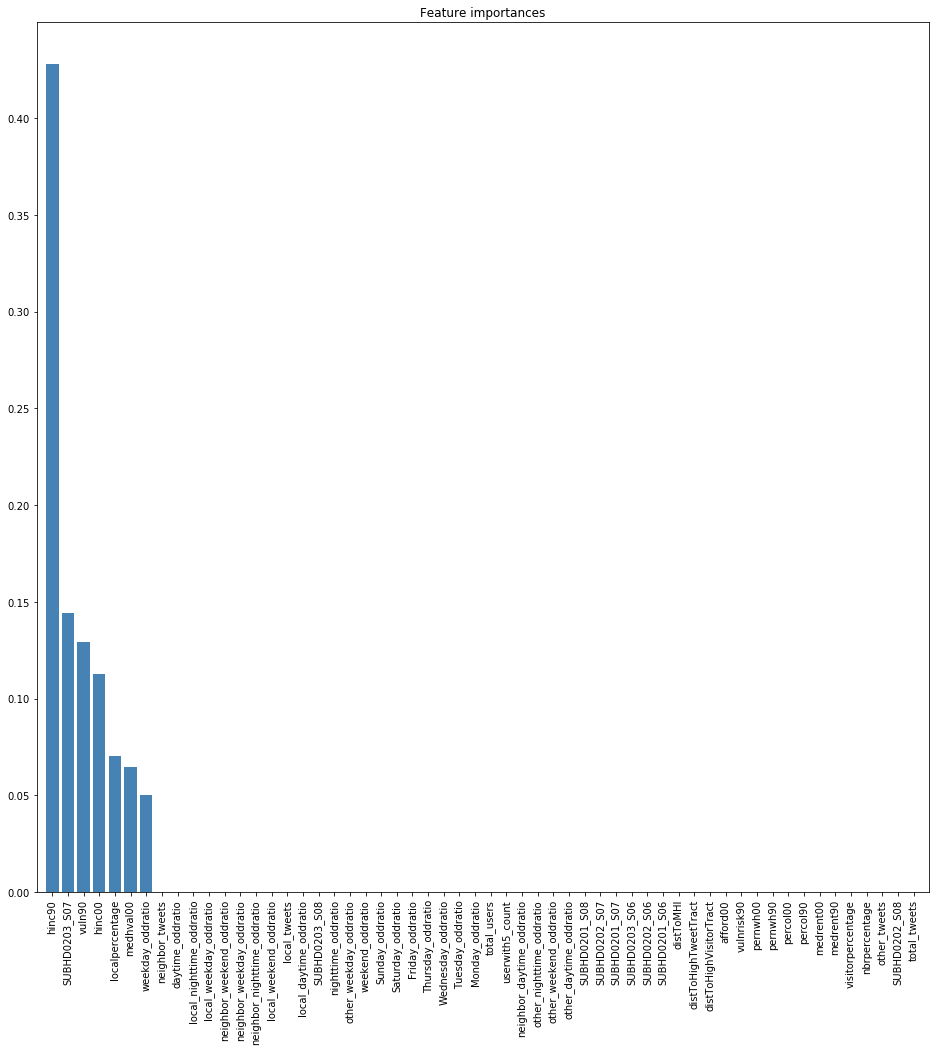

people_target trainscore:  0.881239242685 testscore:  0.832 F1:  0.640776699029 
 [[621  30]
 [ 81  99]]


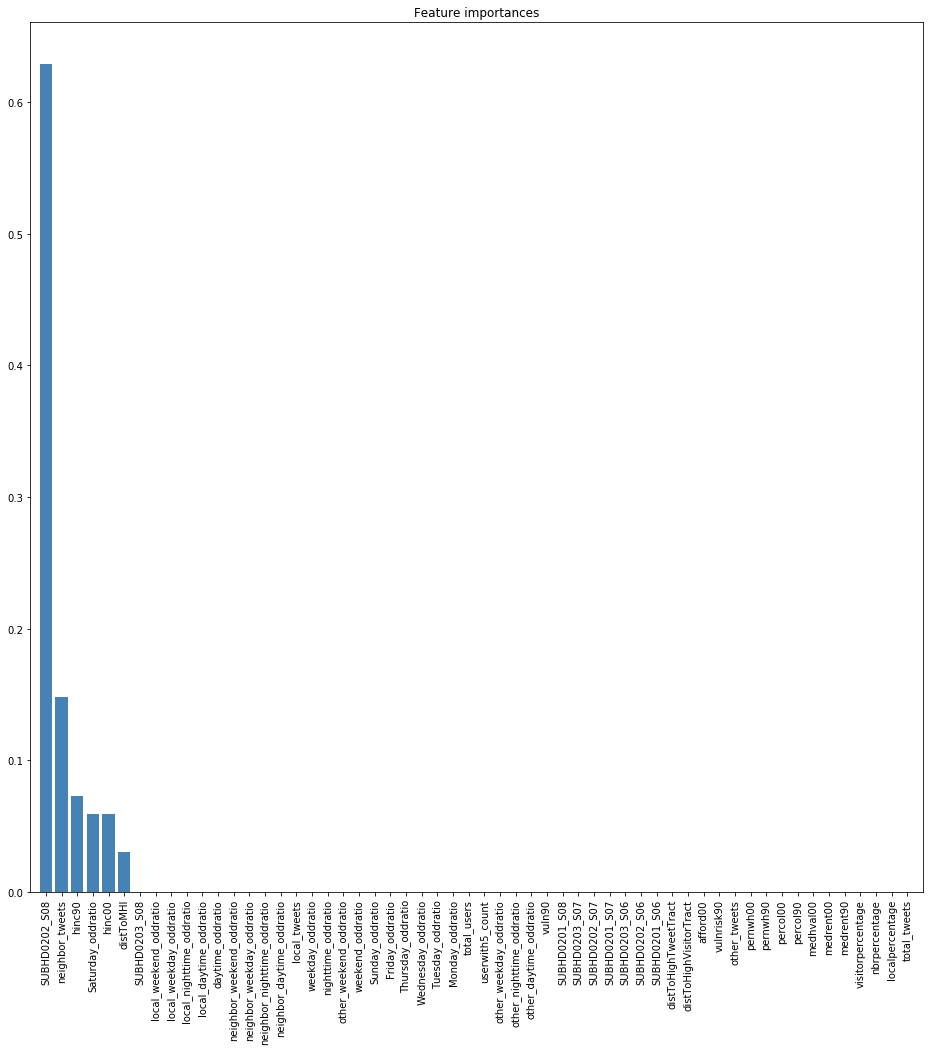

place1_target trainscore:  0.90017211704 testscore:  0.868 F1:  0.599118942731 
 [[672  20]
 [ 71  68]]


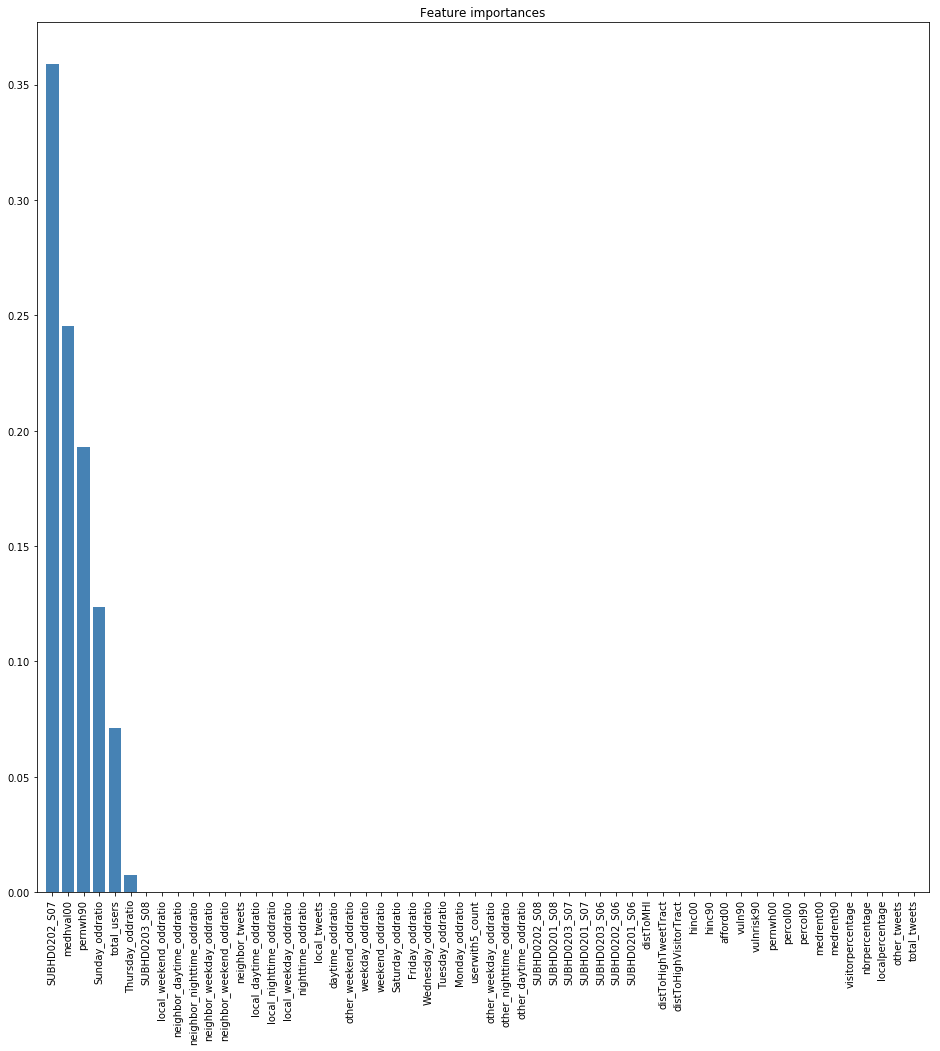

place2_target trainscore:  0.927710843373 testscore:  0.896 F1:  0.956015523933 
 [[ 24  59]
 [  9 739]]


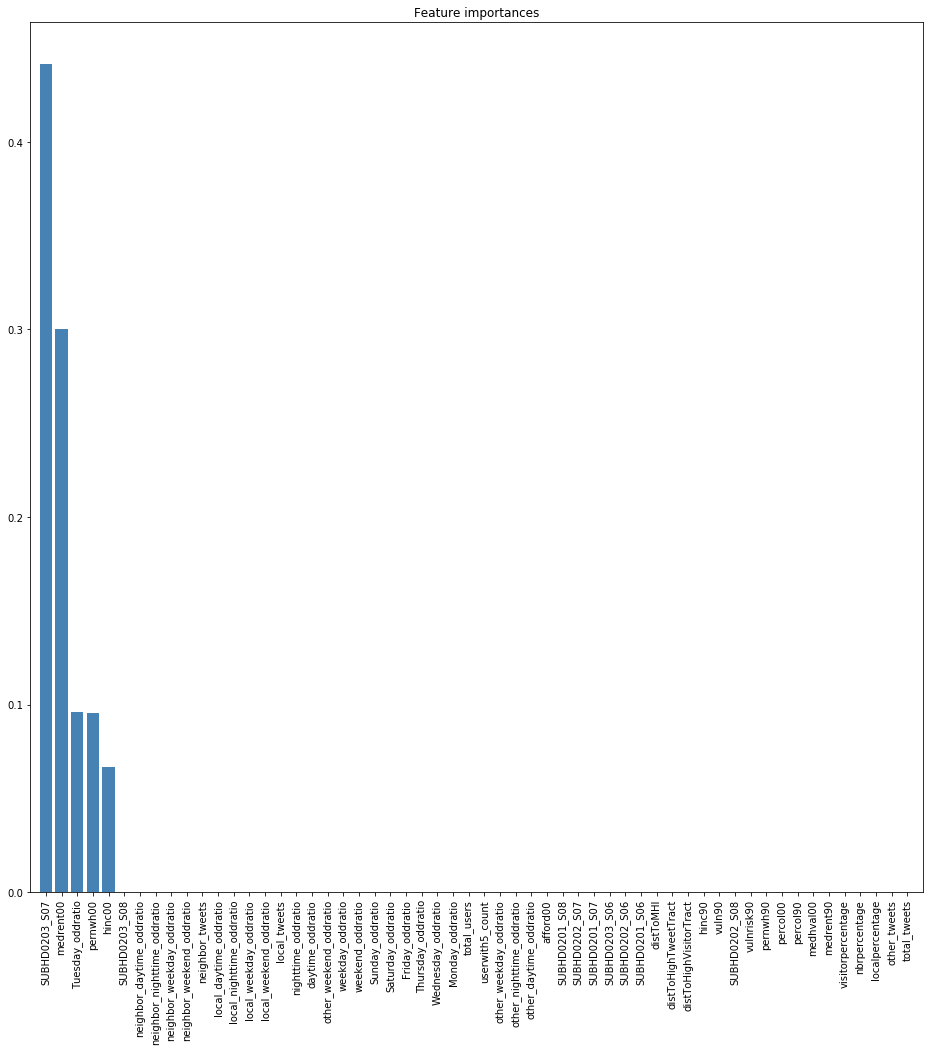

gent16_target trainscore:  0.955249569707 testscore:  0.948 F1:  0.493506493506 
 [[773  13]
 [ 26  19]]


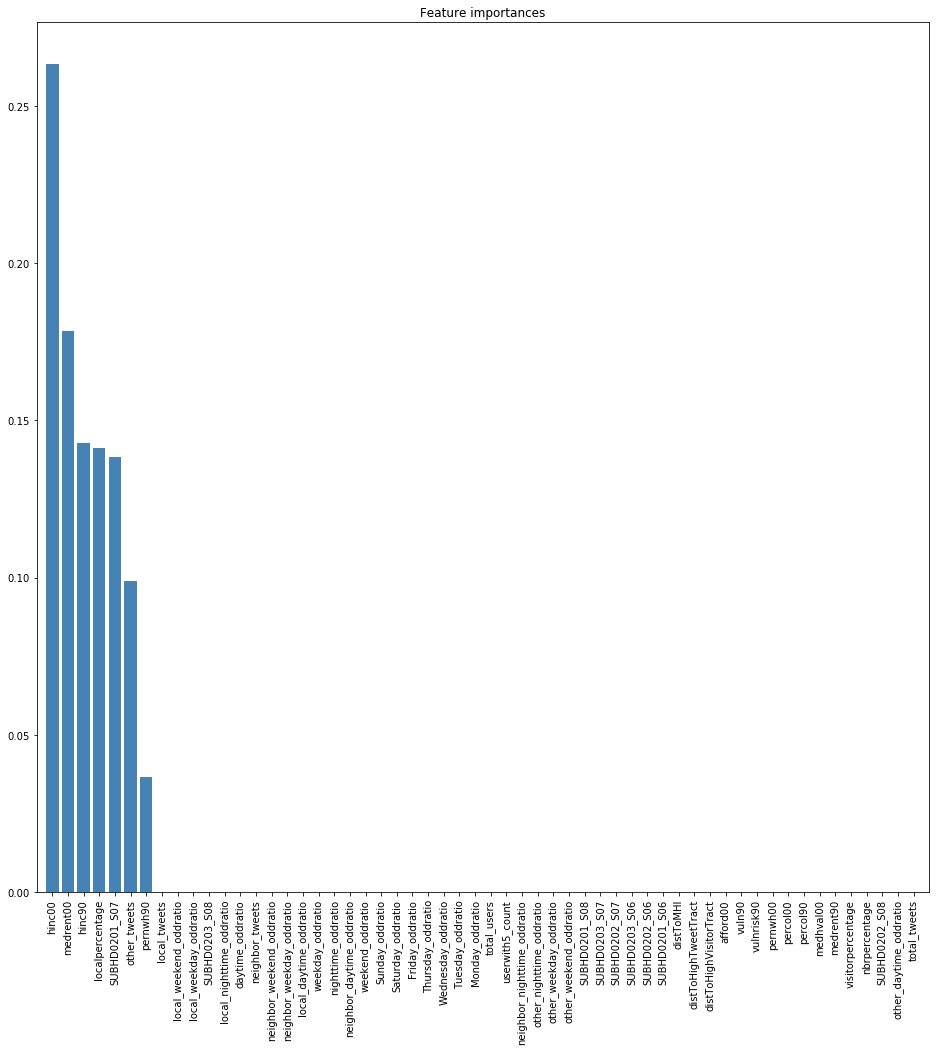

supergent_target trainscore:  1.0 testscore:  0.996 F1:  0.923076923077 
 [[824   0]
 [  1   6]]


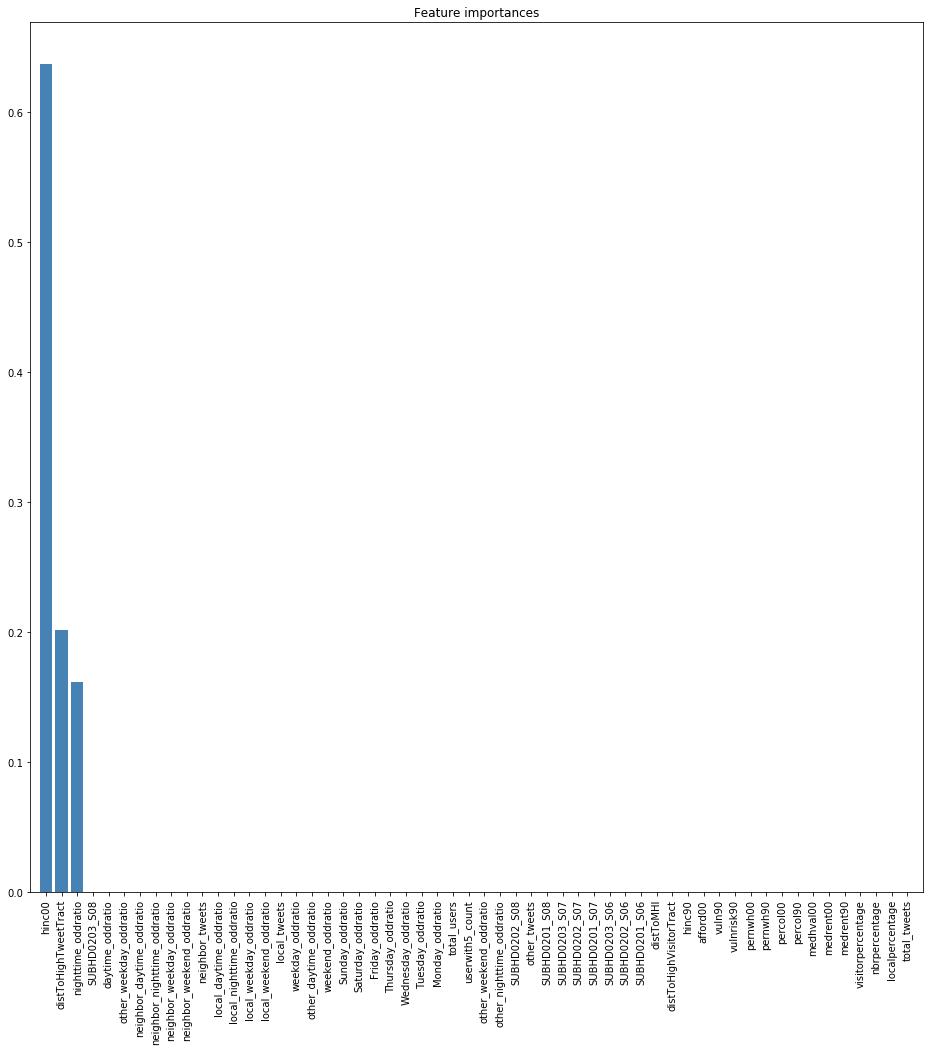

In [95]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    clf4 =  tree.DecisionTreeClassifier(max_depth=3, criterion="gini", random_state=222).fit(modeldata_train, modeltarget_train)
    trainscore = clf4.score(modeldata_train, modeltarget_train)
    testscore = clf4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, clf4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, clf4.predict(modeldata4)) )
    featureImportancePlot(clf4, modeldata4.columns)
    a += 1

In [97]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    logit_4 = LogisticRegression(C = 10000)
    logit_4.fit(modeldata_train, modeltarget_train)
    trainscore = logit_4.score(modeldata_train, modeltarget_train)
    testscore = logit_4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, logit_4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, logit_4.predict(modeldata4)) )
    #featureImportancePlot(logit_4, modeldata4.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.814113597246 testscore:  0.792 F1:  0.0804597701149 
 [[664   4]
 [156   7]]
people_target trainscore:  0.829604130809 testscore:  0.84 F1:  0.475471698113 
 [[629  22]
 [117  63]]
place1_target trainscore:  0.843373493976 testscore:  0.86 F1:  0.350515463918 
 [[671  21]
 [105  34]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

place2_target trainscore:  0.908777969019 testscore:  0.912 F1:  0.951953875721 
 [[ 13  70]
 [  5 743]]
gent16_target trainscore:  0.943201376936 testscore:  0.952 F1:  0.150943396226 
 [[782   4]
 [ 41   4]]
supergent_target trainscore:  1.0 testscore:  0.98 F1:  0.666666666667 
 [[821   3]
 [  2   5]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

In [99]:
targetnames = ['binary', 'people_target', 'place1_target', 'place2_target', 'gent16_target', 'supergent_target']
targets4 = [withnewcenmodel[['Type_binary']], withnewcenmodel[['pct_ch_hinc00_16_binary']], withnewcenmodel[['pct_ch_medhval00_16_binary']], withnewcenmodel[['pct_ch_medrent00_16_binary']], withnewcenmodel[['gent00_16_y']], withnewcenmodel[['Supergent16']]]
withnewcenmodeldata = withnewcenmodel.iloc[:, 0:-6]
a=0 
print('[TN, FP][FN, TP]')
for n in targets4: 
    modeldata4= withnewcenmodeldata
    modeltarget4 = n
    modeldata_train, modeldata_test, modeltarget_train, modeltarget_test = train_test_split(modeldata4, modeltarget4, test_size = 0.3, random_state = 1)
    rf4=RandomForestClassifier()
   # gr=GridSearchCV(rf2,param_grid=param_grid,scoring='accuracy')
   # rs=gr.fit(modeldata_train, modeltarget_train)
    rf4 = RandomForestClassifier(max_depth=3,max_leaf_nodes=6)
    rf4.fit(modeldata_train, modeltarget_train)
    trainscore = rf4.score(modeldata_train, modeltarget_train)
    testscore = rf4.score(modeldata_test, modeltarget_test)
    f1score = metrics.f1_score(modeltarget4, rf4.predict(modeldata4))
    print(targetnames[a], 'trainscore: ', trainscore, 'testscore: ', testscore, 'F1: ', f1score, '\n',  metrics.confusion_matrix(modeltarget4, rf4.predict(modeldata4)) )
    #featureImportancePlot(rf4, modeldata4.columns)
    a += 1

[TN, FP][FN, TP]
binary trainscore:  0.858864027539 testscore:  0.788 F1:  0.341463414634 
 [[661   7]
 [128  35]]
people_target trainscore:  0.865748709122 testscore:  0.848 F1:  0.591549295775 
 [[631  20]
 [ 96  84]]
place1_target trainscore:  0.89156626506 testscore:  0.88 F1:  0.550724637681 
 [[681  11]
 [ 82  57]]
place2_target trainscore:  0.910499139415 testscore:  0.916 F1:  0.953414167198 
 [[ 11  72]
 [  1 747]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

gent16_target trainscore:  0.944922547332 testscore:  0.96 F1:  0.16 
 [[785   1]
 [ 41   4]]
supergent_target trainscore:  0.998278829604 testscore:  0.996 F1:  0.857142857143 
 [[823   1]
 [  1   6]]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


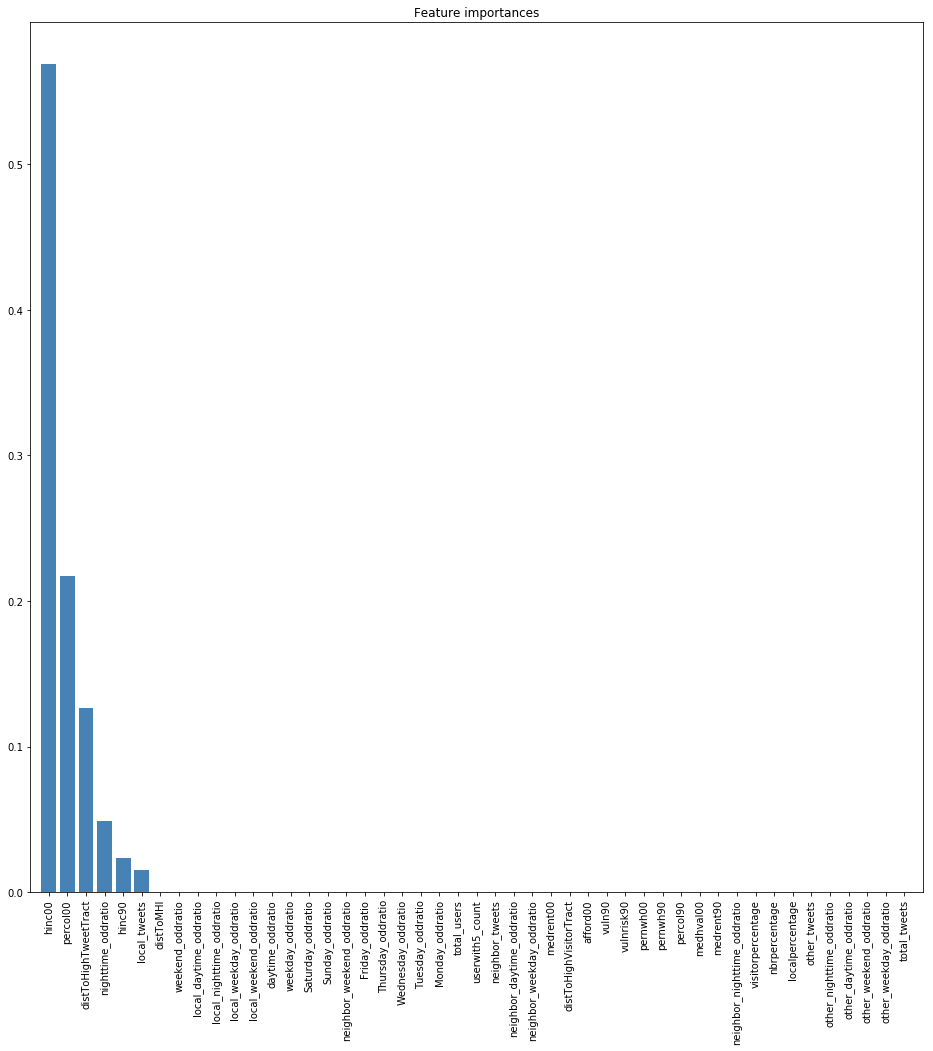

In [101]:
featureImportancePlot(clf3, distmodeldata.columns)

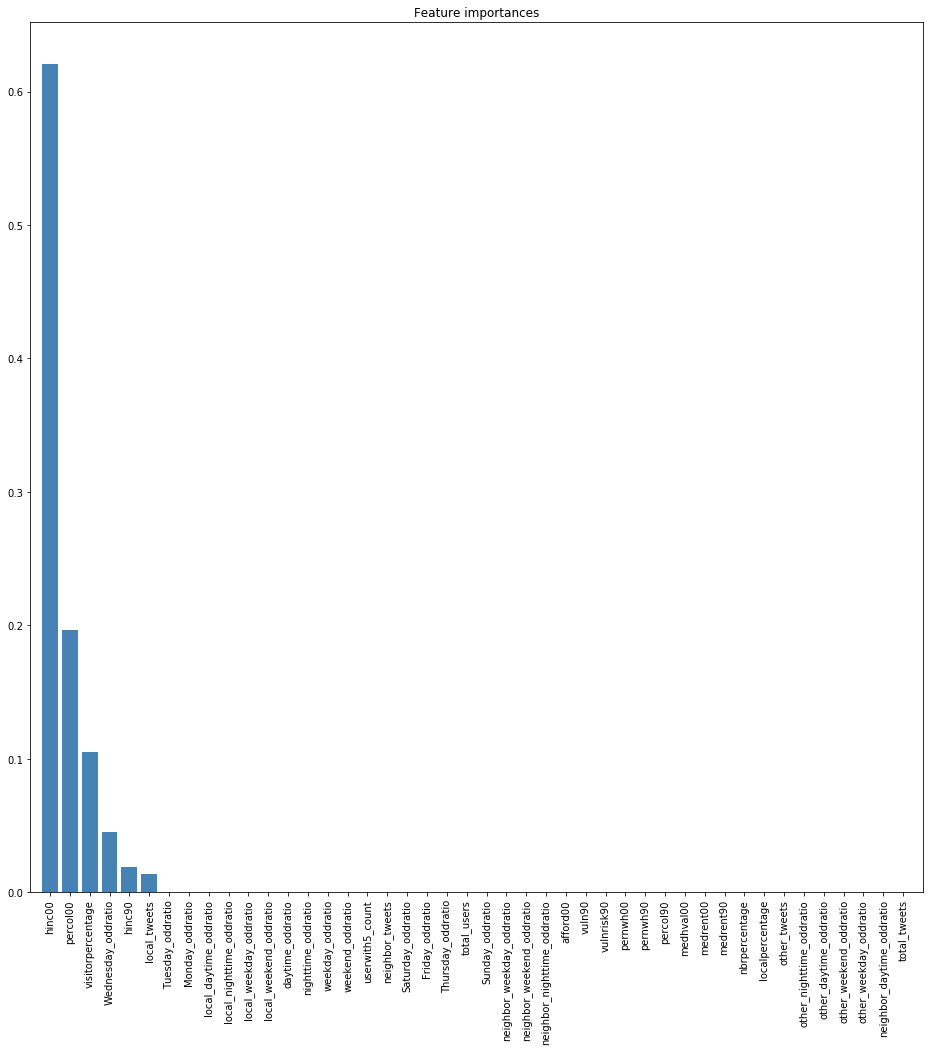

In [102]:
featureImportancePlot(clf2, censusmodeldata.columns)

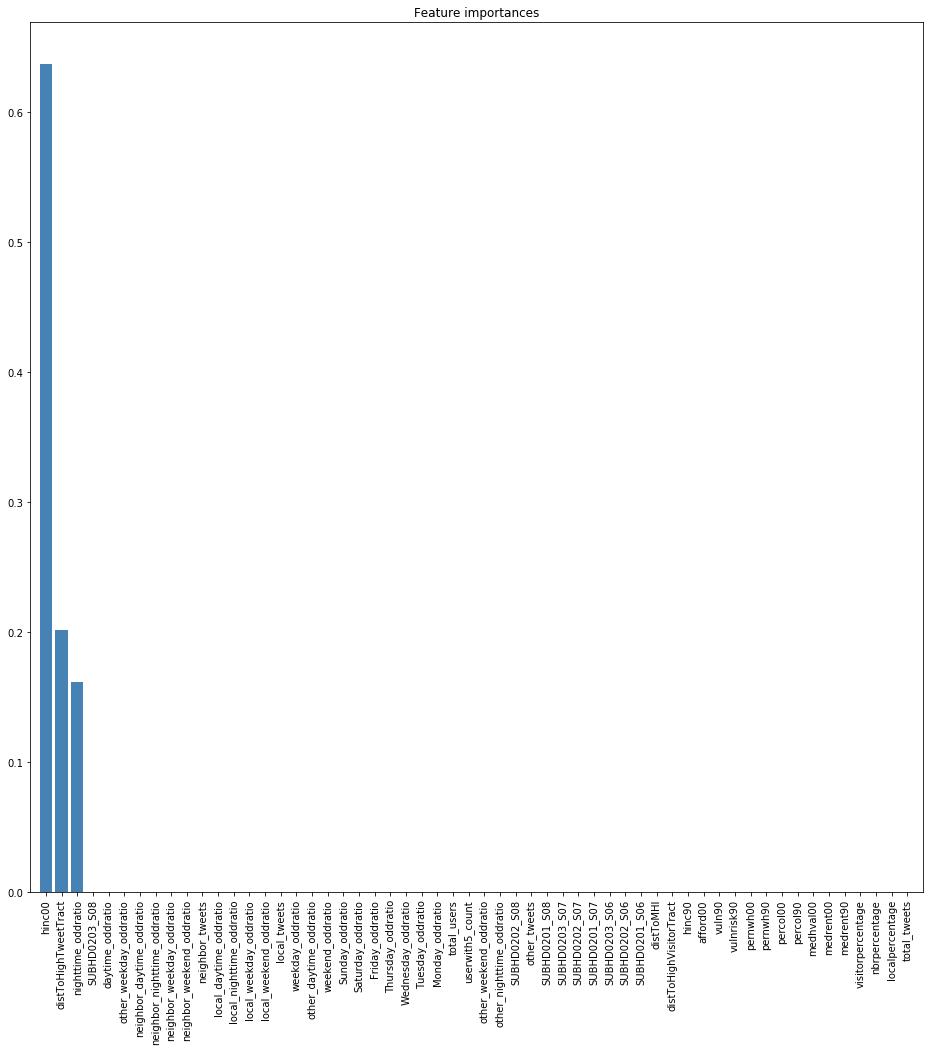

In [103]:
featureImportancePlot(clf4, withnewcenmodel.columns)

In [100]:
#feature importance for logit regression
# def f_importances_pos(coef, names):
#    imp = coef
#    print(imp.shape)
#    imp, names = zip(*sorted(zip(list(imp[0]), names)))
#    imp = imp[:20]
#    names = names[:20]
#    plt.barh(range(len(names)), imp, align='center')
#    plt.yticks(range(len(names)), names)
#    plt.show()